In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import cv2
#from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import backend as K
import tensorflow as tf
from datetime import datetime
import utils
from utils import *
import model
from model import *
from unetEnums import *
import copy

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Set some parameters
_imgWidth = 512
_imgHeight = 512
_imgChannels = 3
_trainPath = '../../datasets/2018_dsb/stage1_train_fixed/'
_testPath = '../../datasets/2018_dsb/stage2_test_final/'
_extraDataPath = '../../datasets/2018_dsb/extra_data/'

# Root directory of the project
_rootDir = os.getcwd()

# Directory to save logs and trained model
_modelDir = os.path.join(_rootDir, "logs")

_batchSize = 4
_validationSplit = 0.1
_epochs = 100

_contourThickness = 3

# Get the data

In [3]:
train_ids, X_train, Y_train, spaceBetweenTrain, concatenatedMasksTrain = utils.load_dataset(_trainPath, _imgWidth, _imgHeight, _imgChannels, datasetType = DataType.trainData, contourThickness = _contourThickness)
extra_data_ids, X_extra_data, Y_extra_data, spaceBetween_extra_data, concatenatedMasks_extra_data = utils.load_dataset(_extraDataPath, _imgWidth, _imgHeight, _imgChannels, datasetType=DataType.extraData, contourThickness = _contourThickness)
test_ids, X_test, sizes_test = utils.load_dataset(_testPath, _imgWidth, _imgHeight, _imgChannels, datasetType=DataType.testData, contourThickness = _contourThickness)

trying to load the numpy arrays from binary files
Done!
trying to load the numpy arrays from binary files
Done!
trying to load the numpy arrays from binary files
Done!


In [4]:
print(len(train_ids))

664


# Split training set to get validation data

In [5]:
numberOfValidationImages = round(len(train_ids)*_validationSplit)
indices = random.sample(range(0, len(train_ids)), numberOfValidationImages)

val_ids = []
X_val = np.zeros((numberOfValidationImages, _imgHeight, _imgWidth, _imgChannels), dtype=np.uint8)
Y_val = np.zeros((numberOfValidationImages, _imgHeight, _imgWidth, 1), dtype=np.bool)
spaceBetweenVal = np.zeros((numberOfValidationImages, _imgHeight, _imgWidth, 1), dtype=np.bool)
concatenatedMasksVal = np.zeros((numberOfValidationImages, _imgHeight, _imgWidth, 2), dtype=np.bool)

train_ids_without_val = train_ids
X_train_without_val = X_train
Y_train_without_val = Y_train
spaceBetweenTrain_without_val = spaceBetweenTrain
concatenatedMasksTrain_without_val = concatenatedMasksTrain

for n, index in tqdm(enumerate(sorted(indices, reverse=True)), total=len(indices)):
    val_ids.append(train_ids[index])
    train_ids_without_val = np.delete(train_ids_without_val, index, axis=0)
    
    X_val[n] = X_train[index]
    X_train_without_val = np.delete(X_train_without_val, index, axis=0)
    
    Y_val[n] = Y_train[index]
    Y_train_without_val = np.delete(Y_train_without_val, index, axis=0)
    
    spaceBetweenVal[n] = spaceBetweenTrain[index]
    spaceBetweenTrain_without_val = np.delete(spaceBetweenTrain_without_val, index, axis=0)
    
    concatenatedMasksVal[n] = concatenatedMasksTrain[index]
    concatenatedMasksTrain_without_val = np.delete(concatenatedMasksTrain_without_val, index, axis=0)



In [6]:
print(len(X_train))
print(len(Y_train))
print(len(spaceBetweenTrain))
print(len(concatenatedMasksTrain))

print(len(X_train_without_val))
print(len(Y_train_without_val))
print(len(spaceBetweenTrain_without_val))
print(len(concatenatedMasksTrain_without_val))

print(numberOfValidationImages)
print(len(X_val))
print(len(Y_val))
print(len(spaceBetweenVal))
print(len(concatenatedMasksVal))

664
664
664
664
598
598
598
598
66
66
66
66
66


# Visualize the datasets

In [7]:
print(len(train_ids))
print(X_train.shape)
print(Y_train.shape)
print(spaceBetweenTrain.shape)
print(concatenatedMasksTrain.shape)

664
(664, 512, 512, 3)
(664, 512, 512, 1)
(664, 512, 512, 1)
(664, 512, 512, 2)


0


/tmp/scikit-image/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


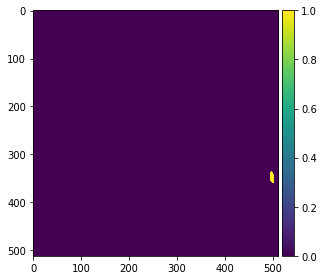

1


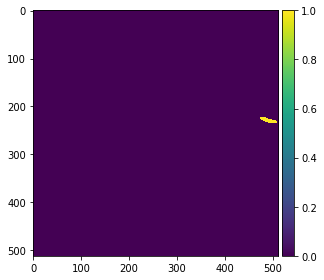

2


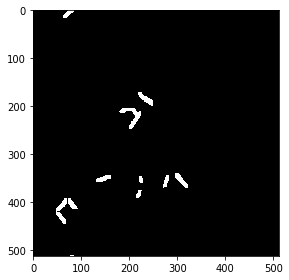

3


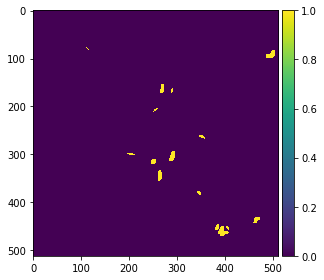

4


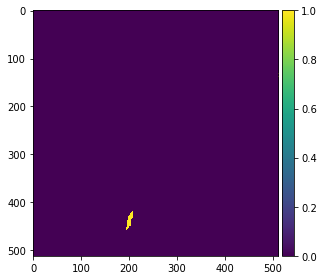

5


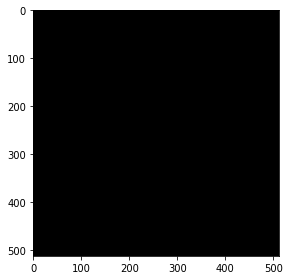

6


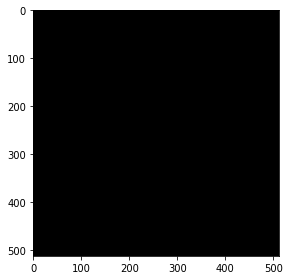

7


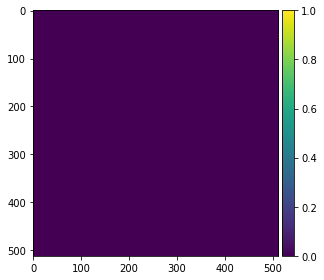

8


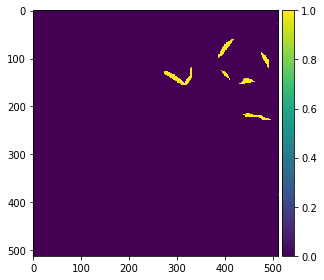

9


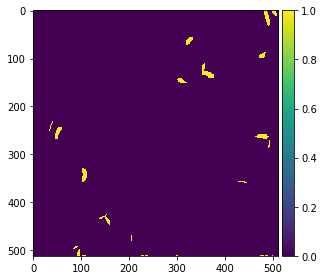

10


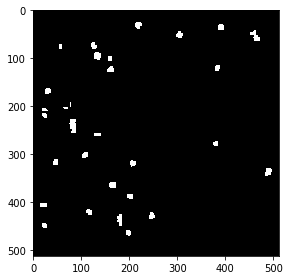

11


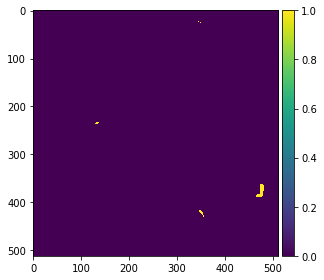

12


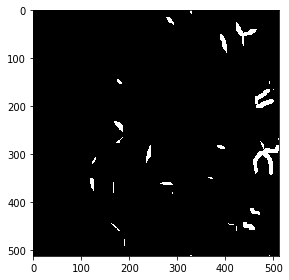

13


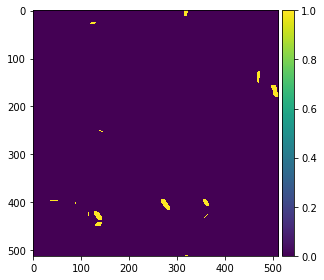

14


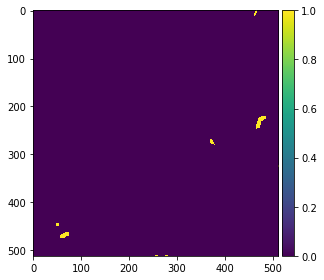

15


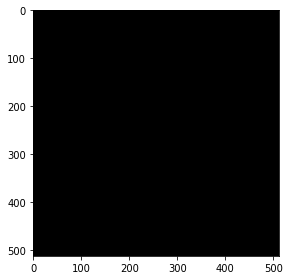

16


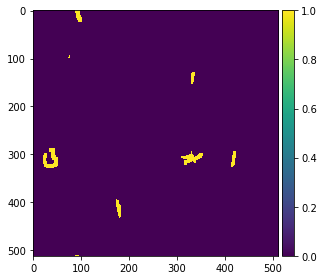

17


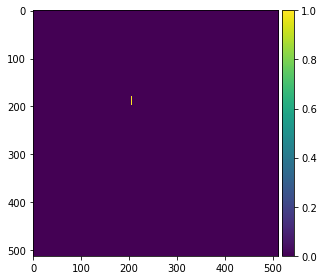

18


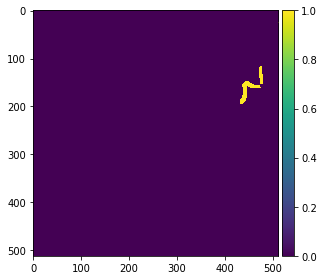

19


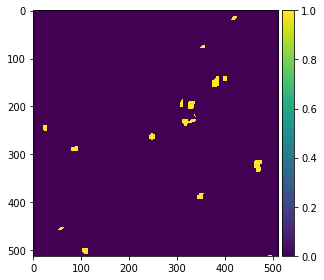

20


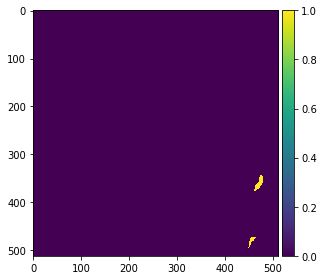

21


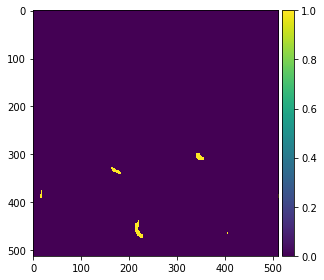

22


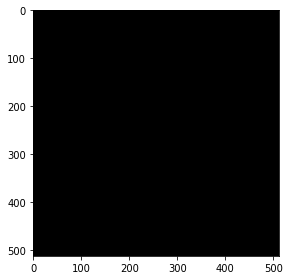

23


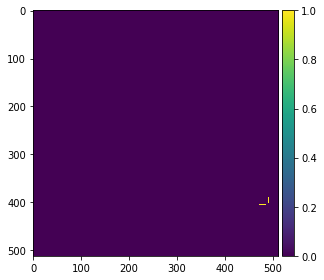

24


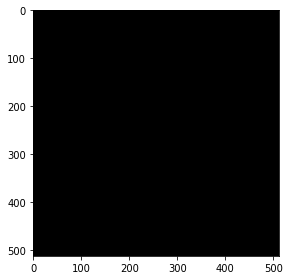

25


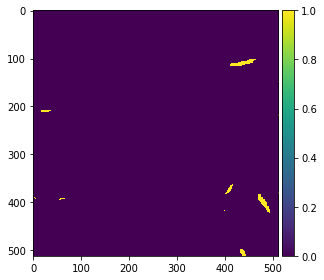

26


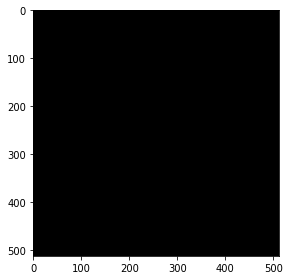

27


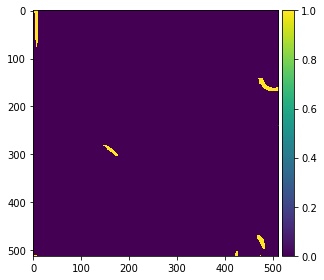

28


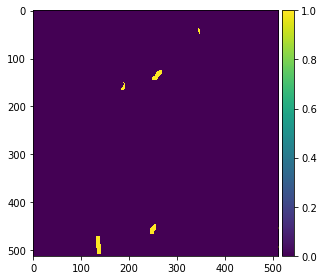

29


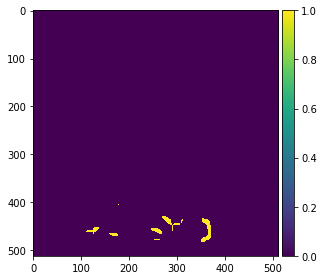

30


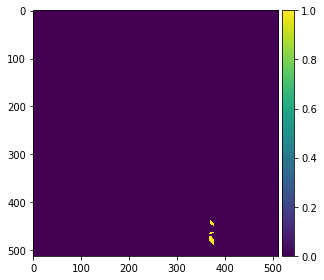

31


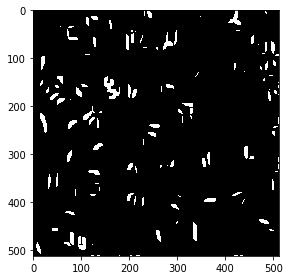

32


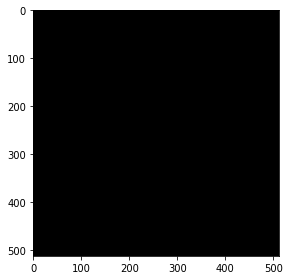

33


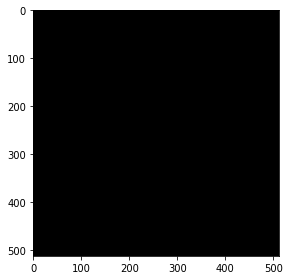

34


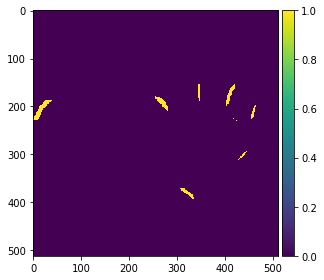

35


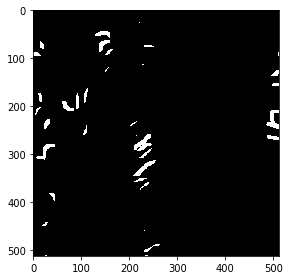

36


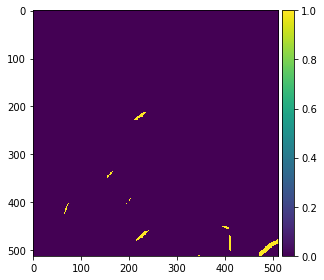

37


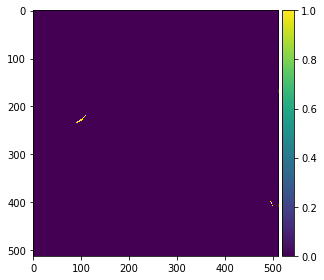

38


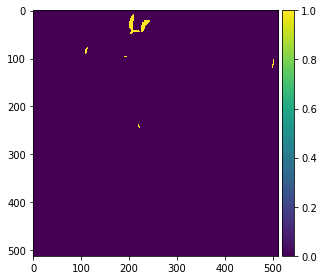

39


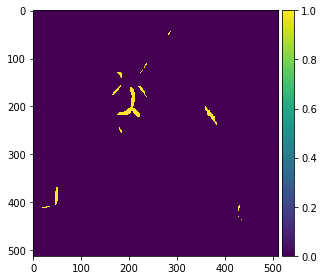

40


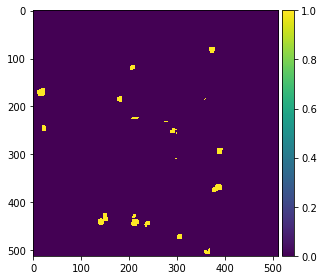

41


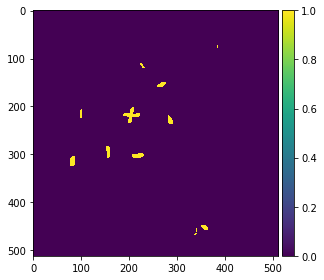

42


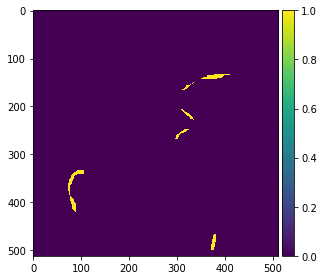

43


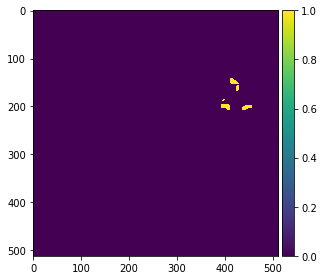

44


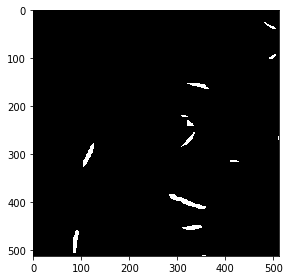

45


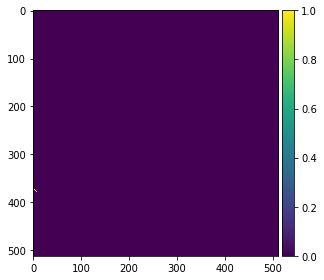

46


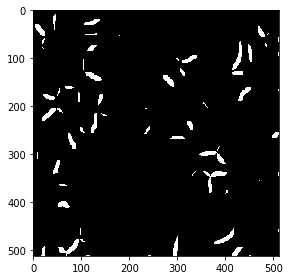

47


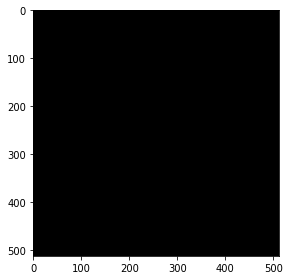

48


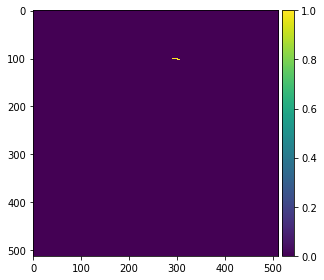

49


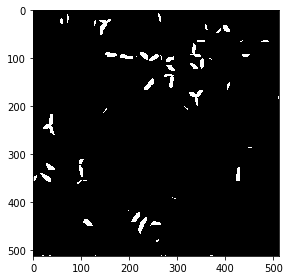

50


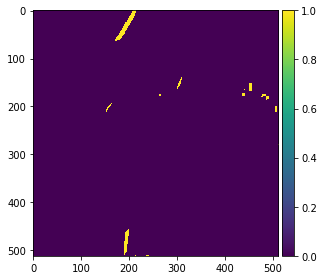

51


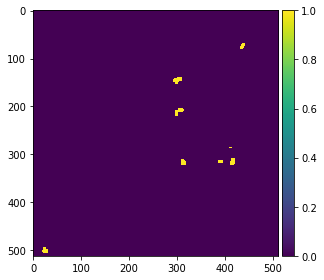

52


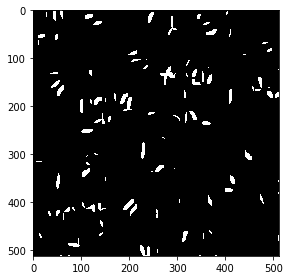

53


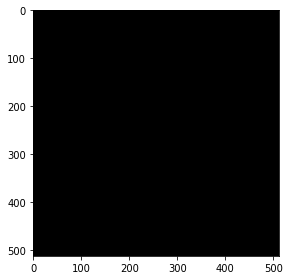

54


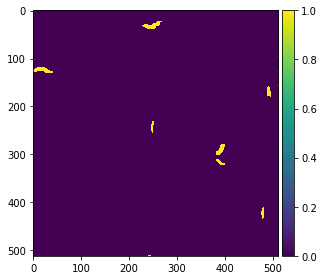

55


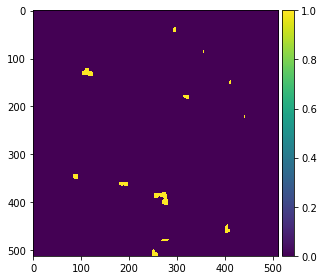

56


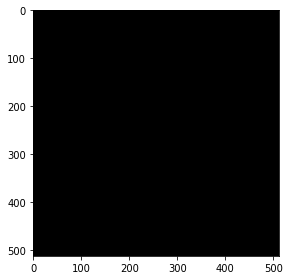

57


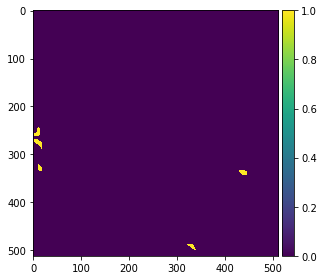

58


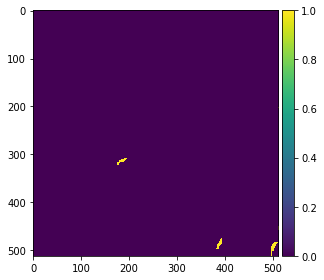

59


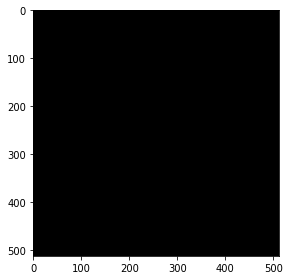

60


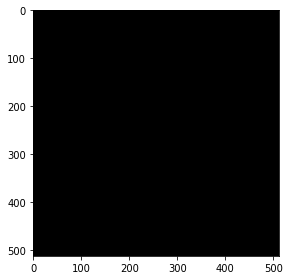

61


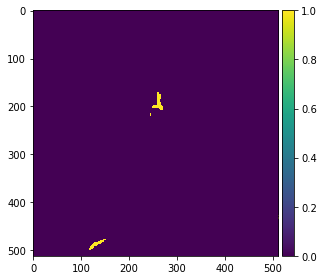

62


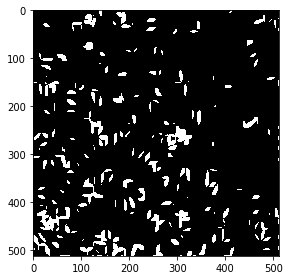

63


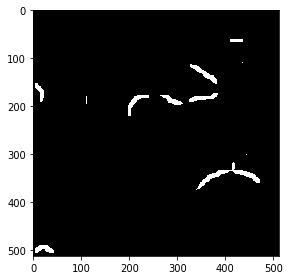

64


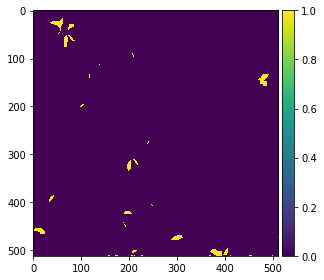

65


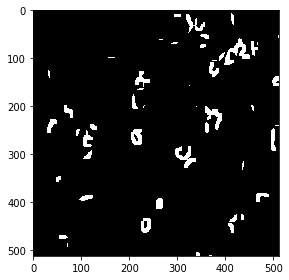

66


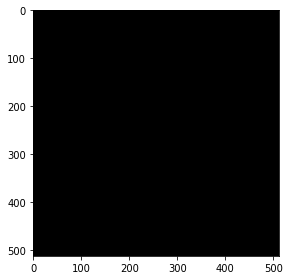

67


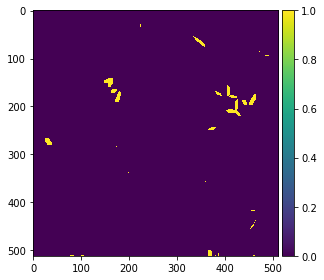

68


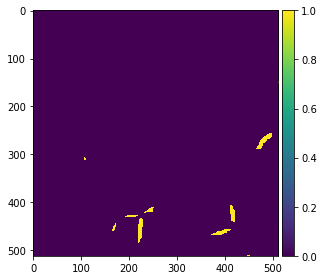

69


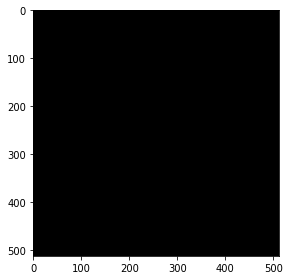

70


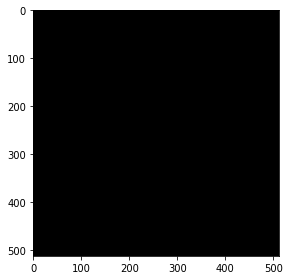

71


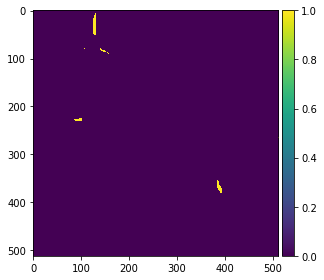

72


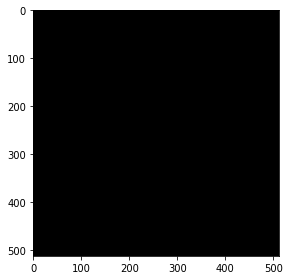

73


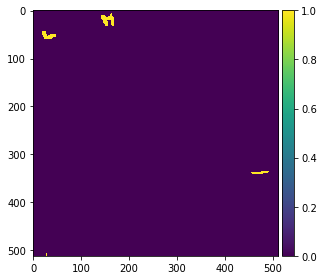

74


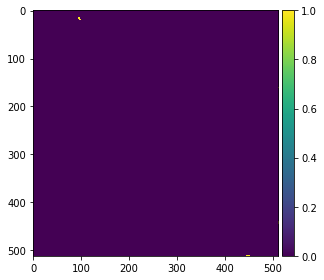

75


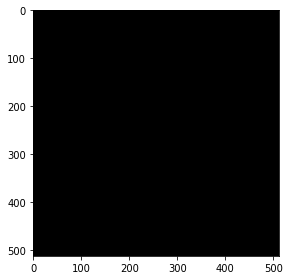

76


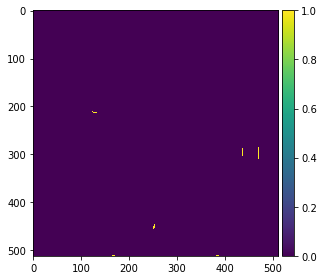

77


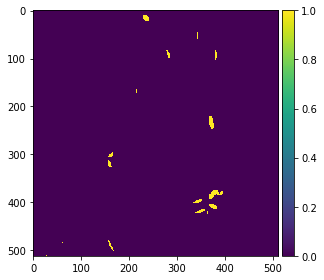

78


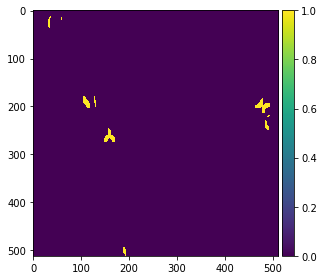

79


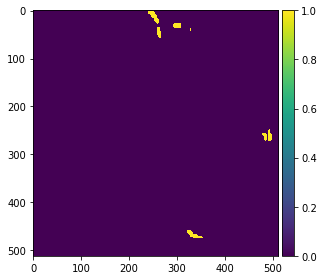

80


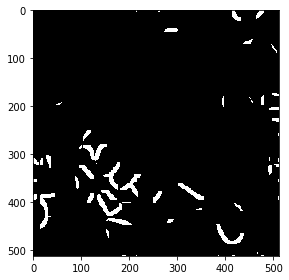

81


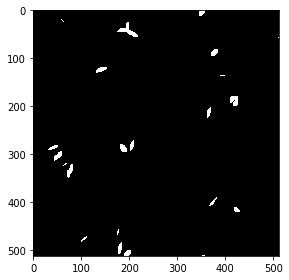

82


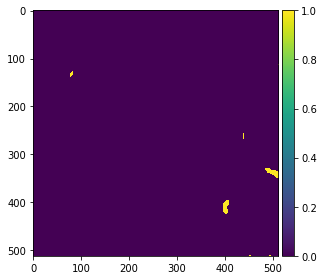

83


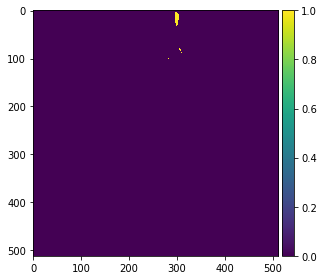

84


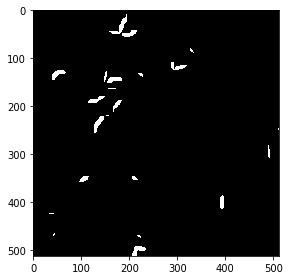

85


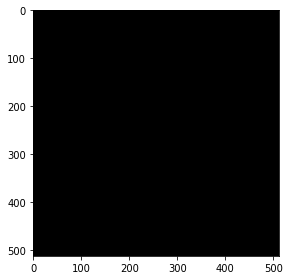

86


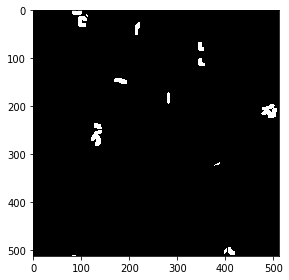

87


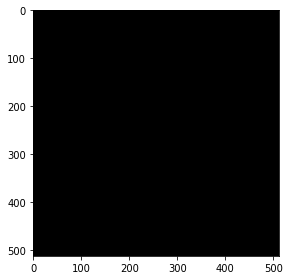

88


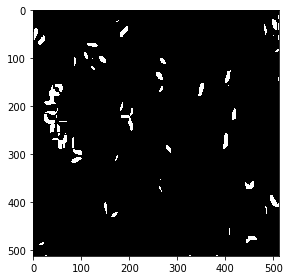

89


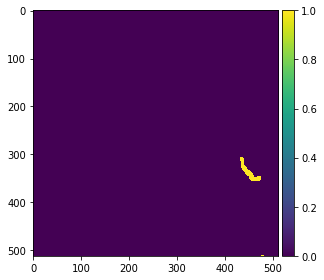

90


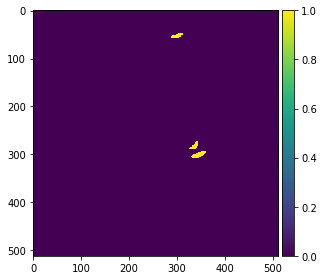

91


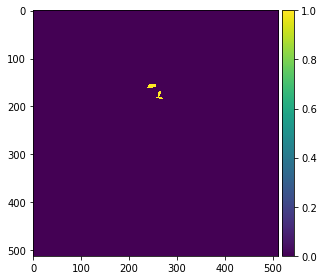

92


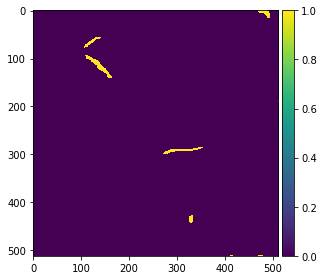

93


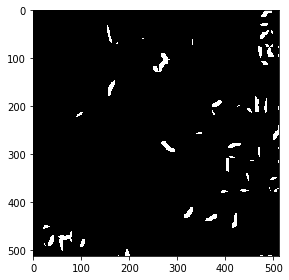

94


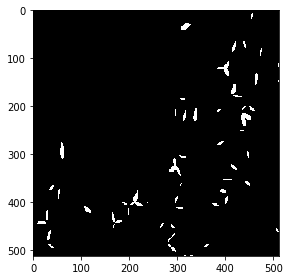

95


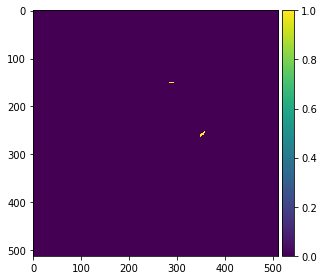

96


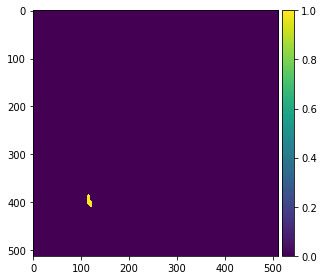

97


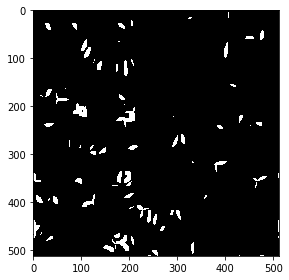

98


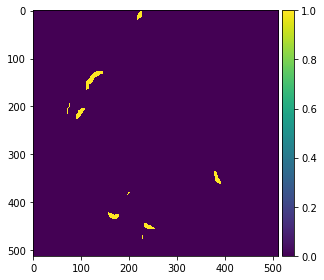

99


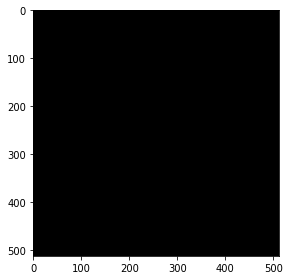

100


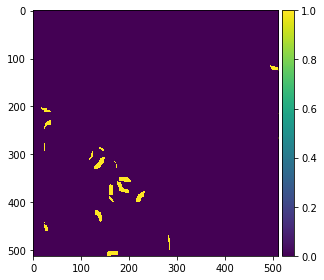

101


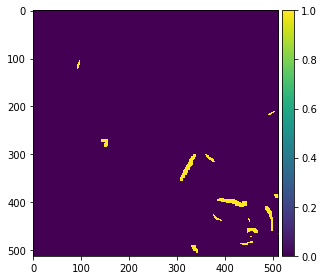

102


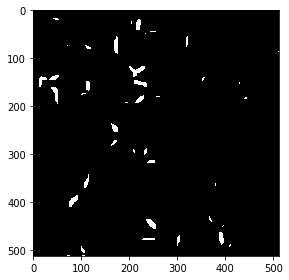

103


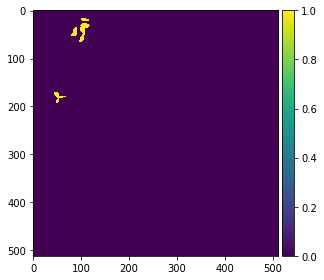

104


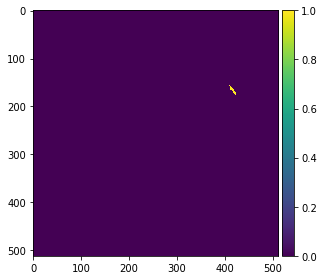

105


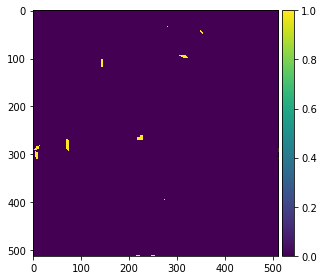

106


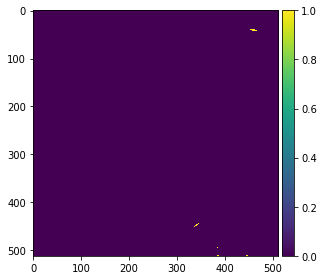

107


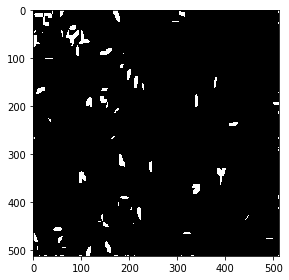

108


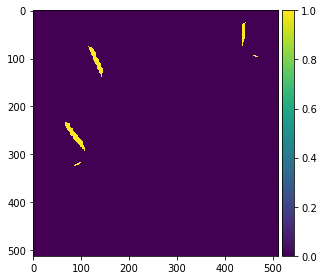

109


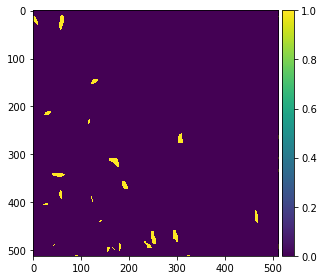

110


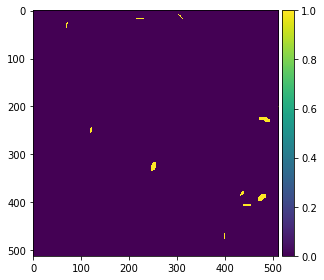

111


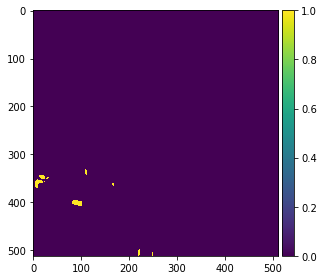

112


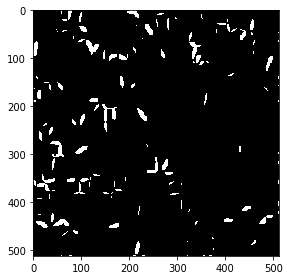

113


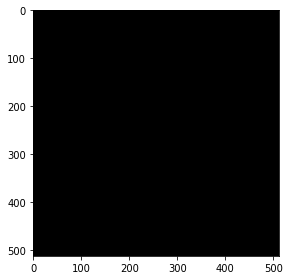

114


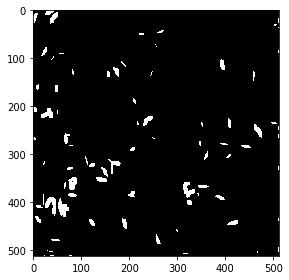

115


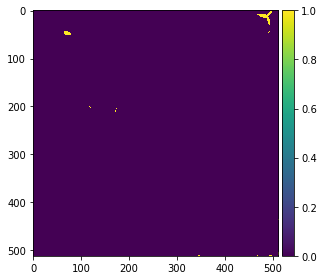

116


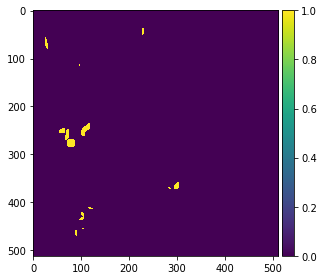

117


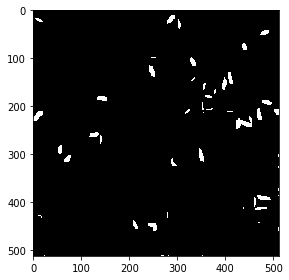

118


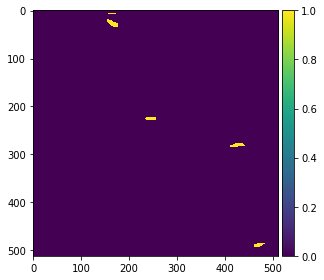

119


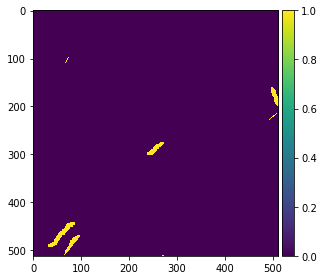

120


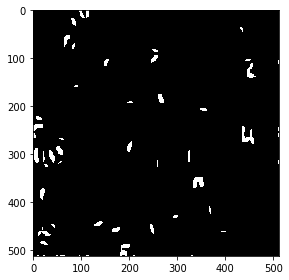

121


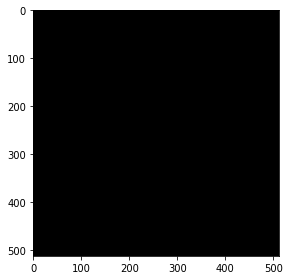

122


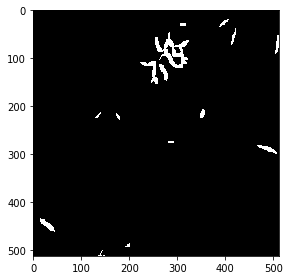

123


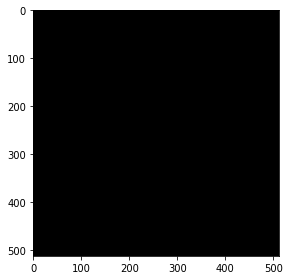

124


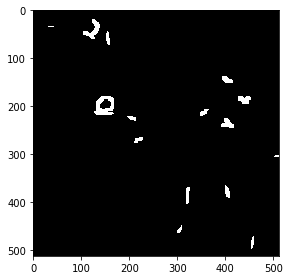

125


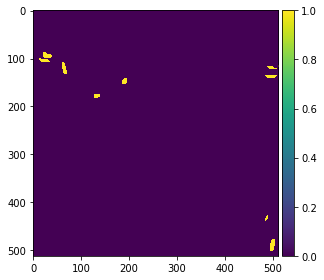

126


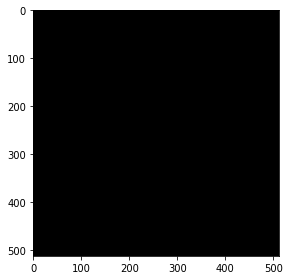

127


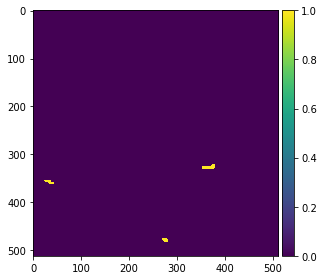

128


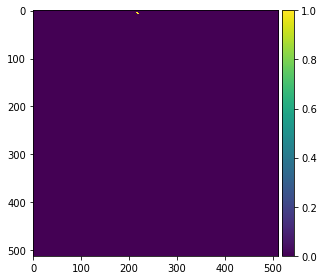

129


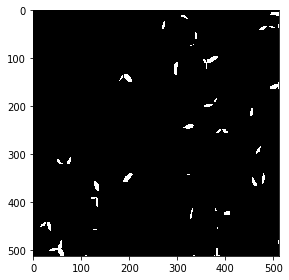

130


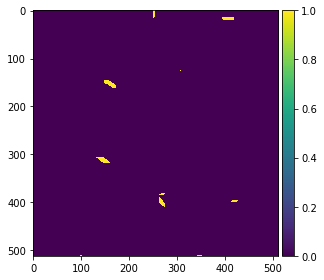

131


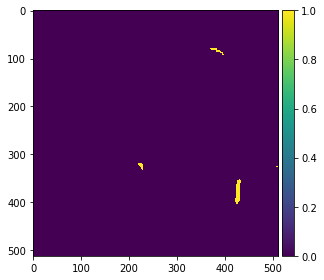

132


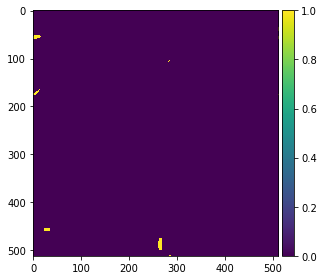

133


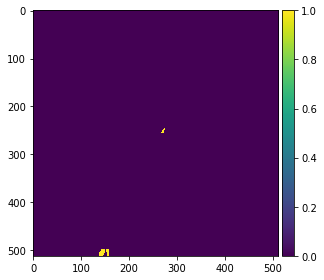

134


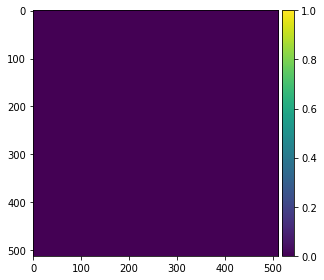

135


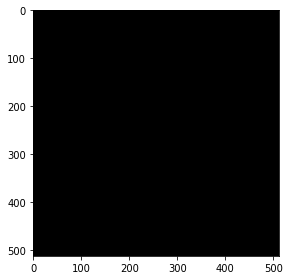

136


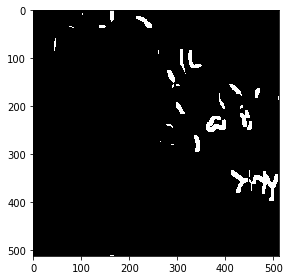

137


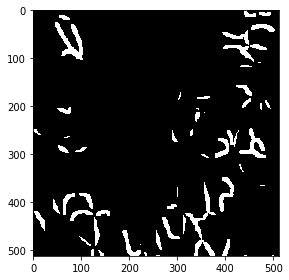

138


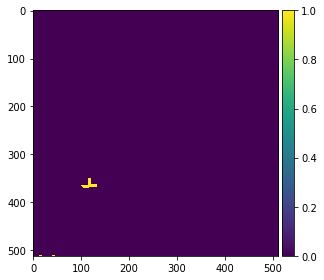

139


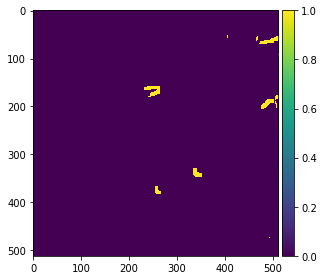

140


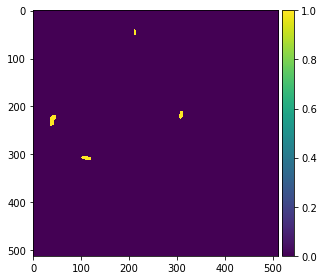

141


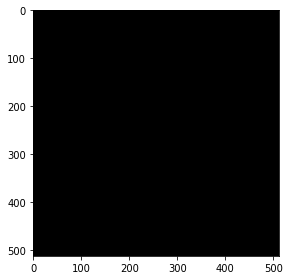

142


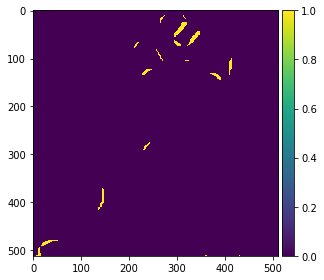

143


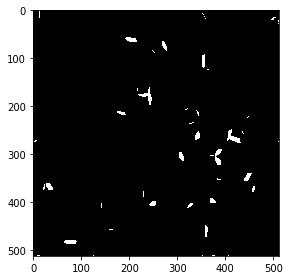

144


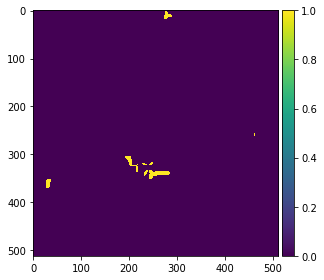

145


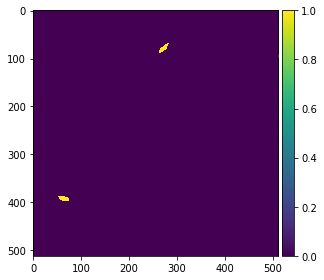

146


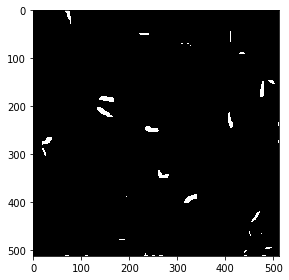

147


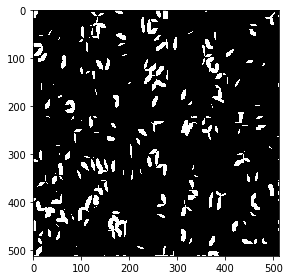

148


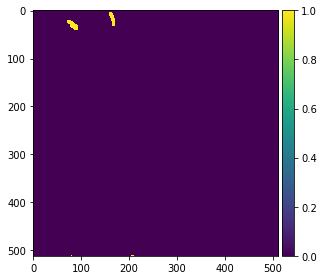

149


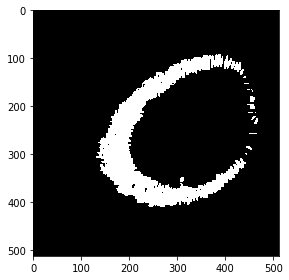

150


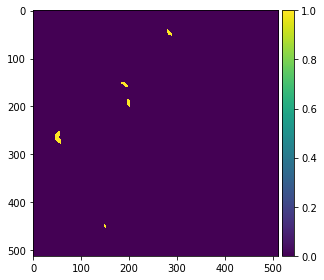

151


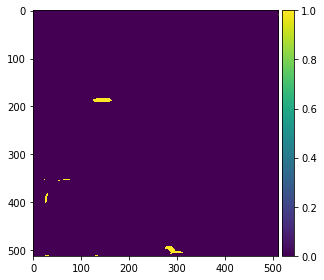

152


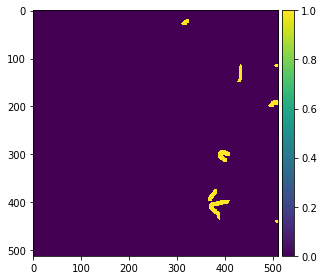

153


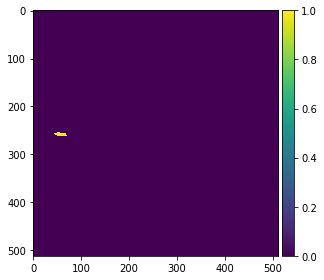

154


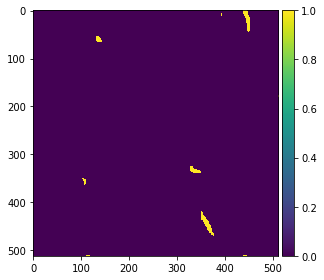

155


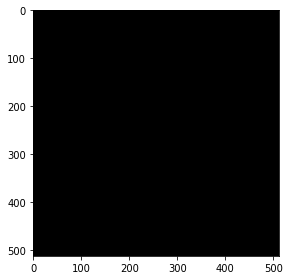

156


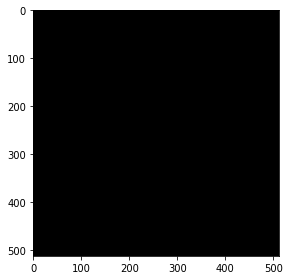

157


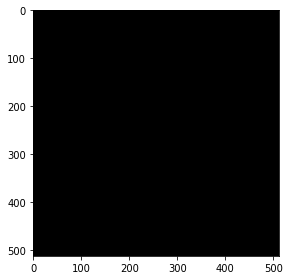

158


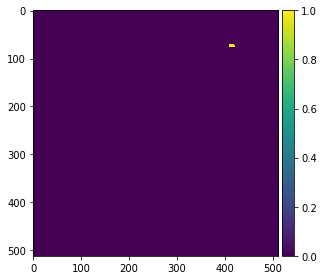

159


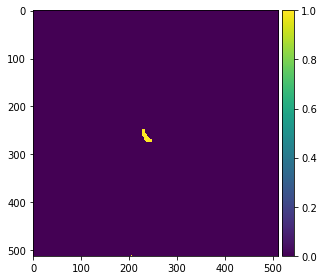

160


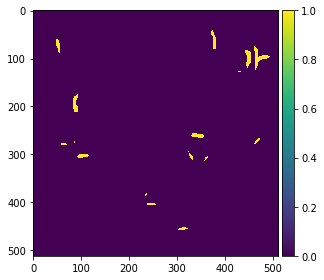

161


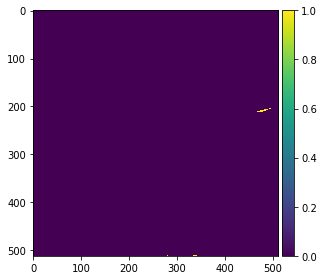

162


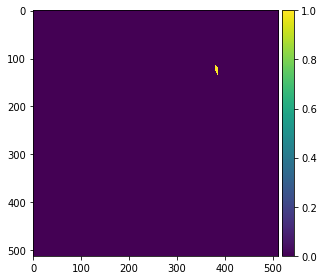

163


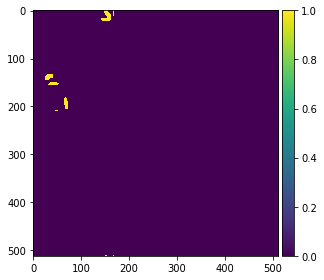

164


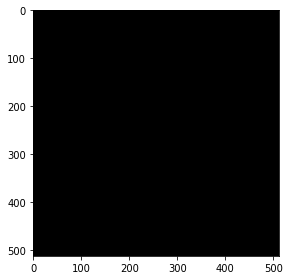

165


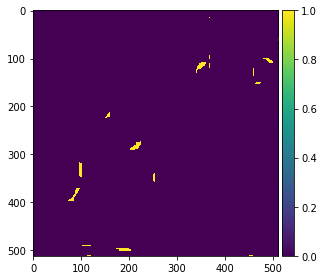

166


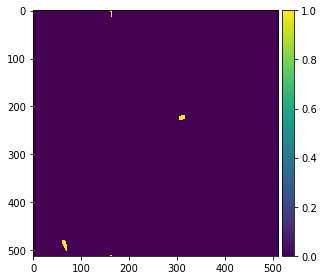

167


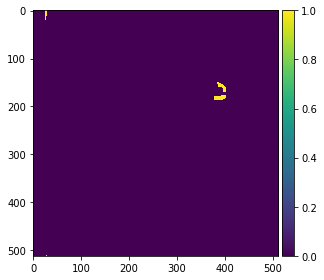

168


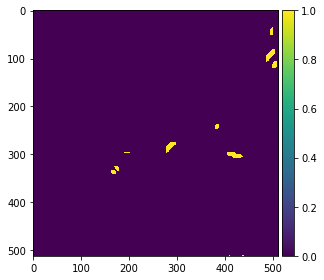

169


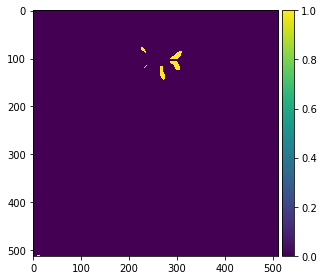

170


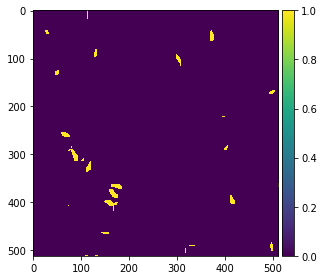

171


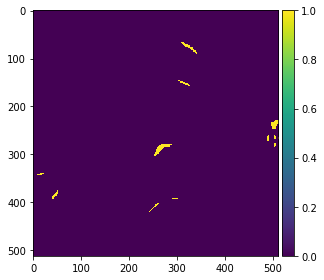

172


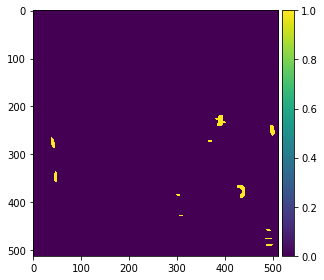

173


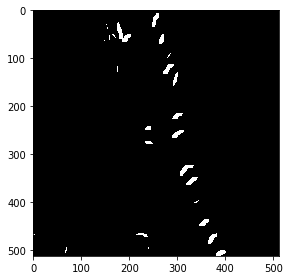

174


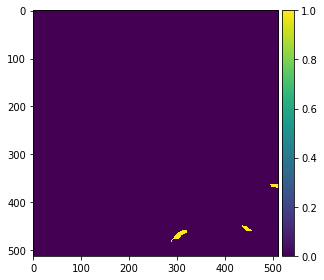

175


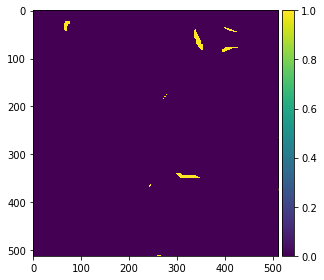

176


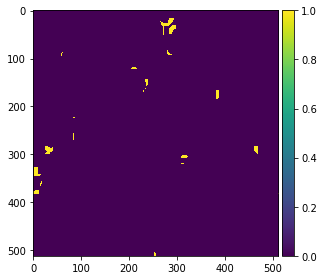

177


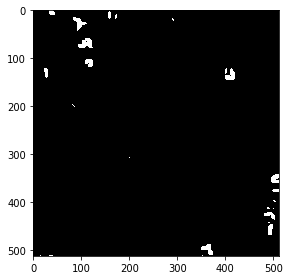

178


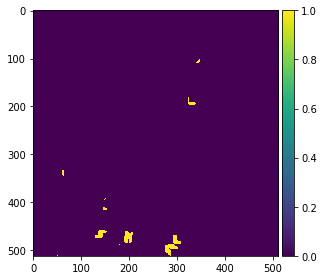

179


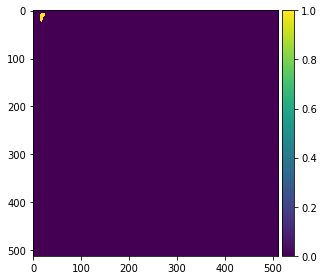

180


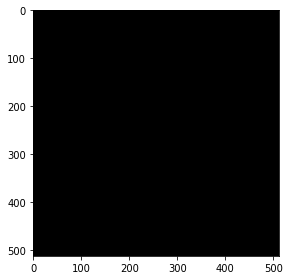

181


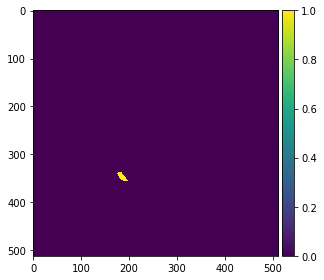

182


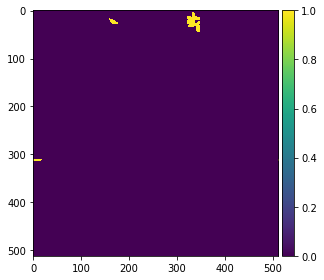

183


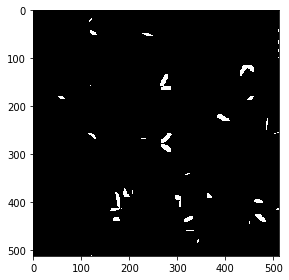

184


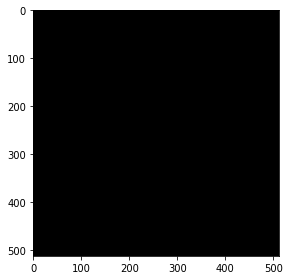

185


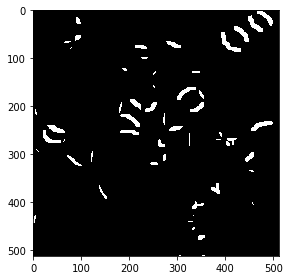

186


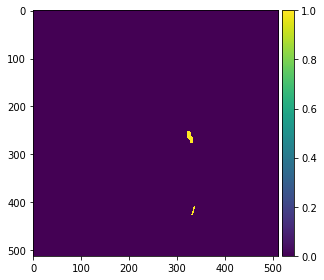

187


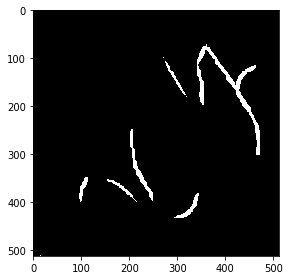

188


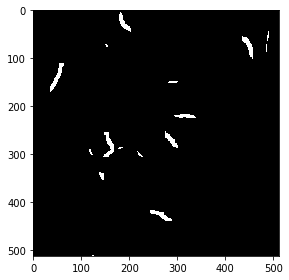

189


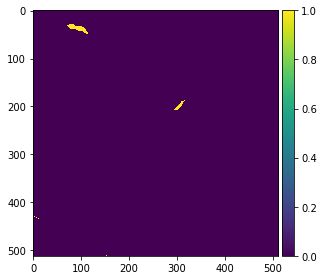

190


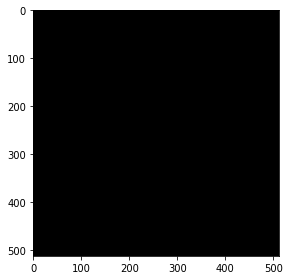

191


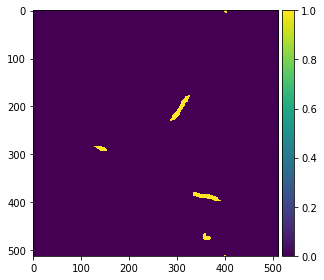

192


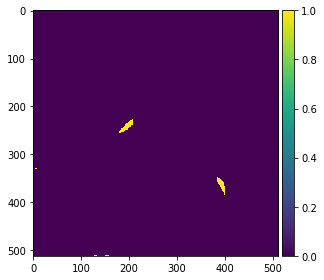

193


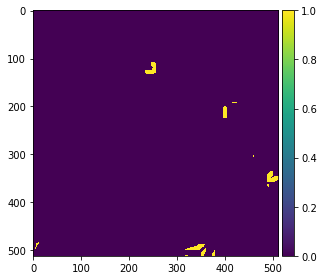

194


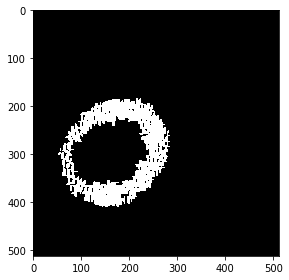

195


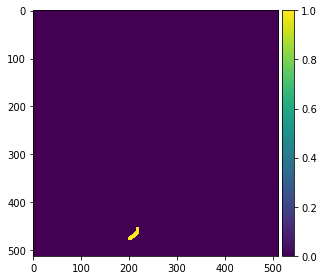

196


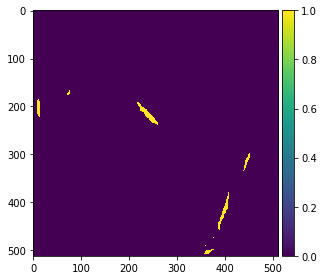

197


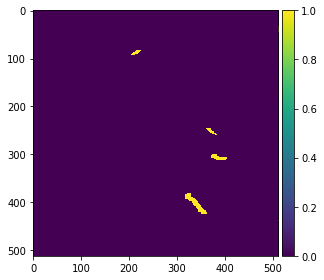

198


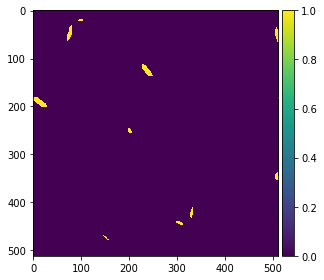

199


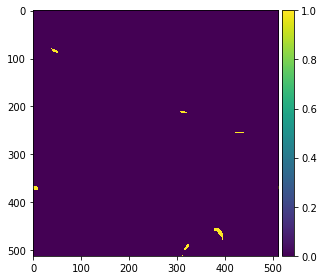

200


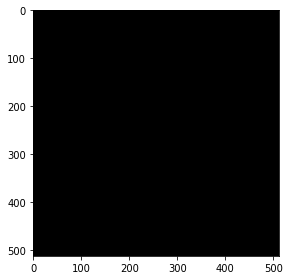

201


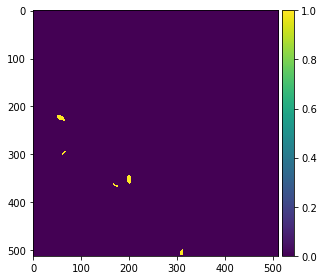

202


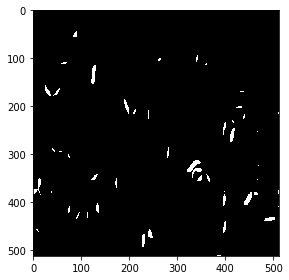

203


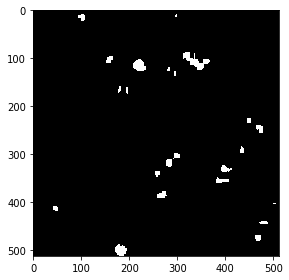

204


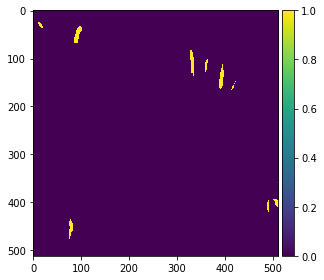

205


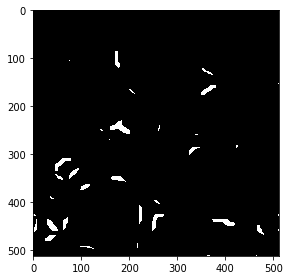

206


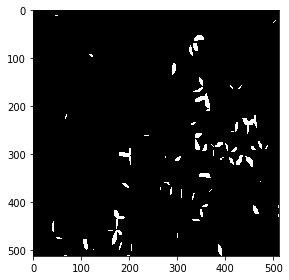

207


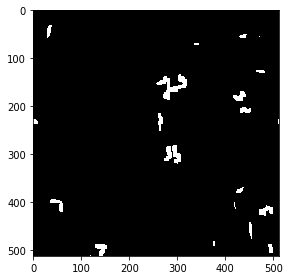

208


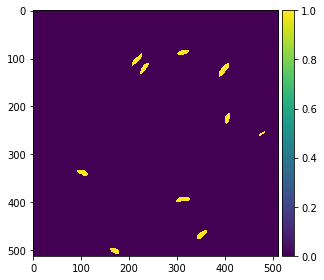

209


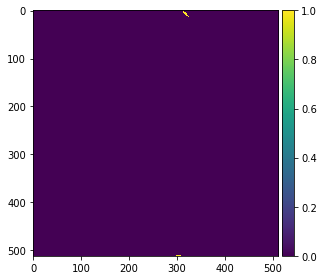

210


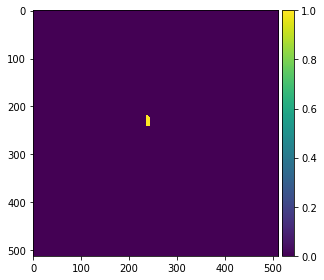

211


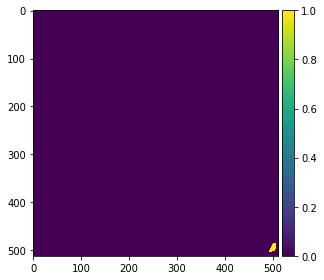

212


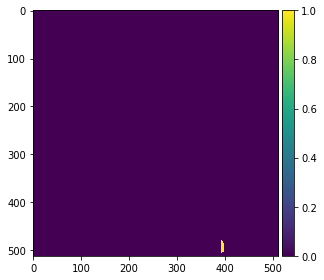

213


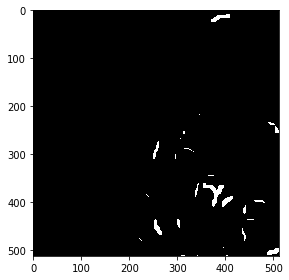

214


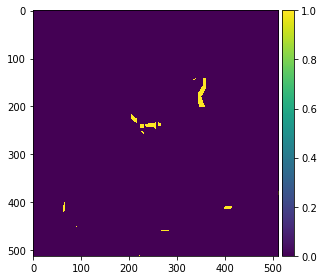

215


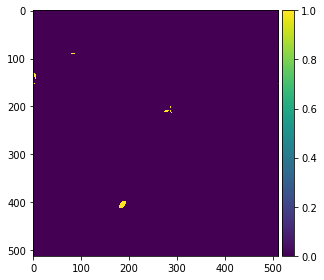

216


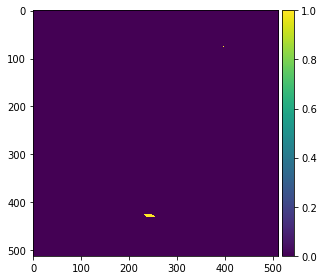

217


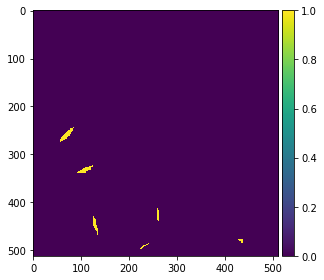

218


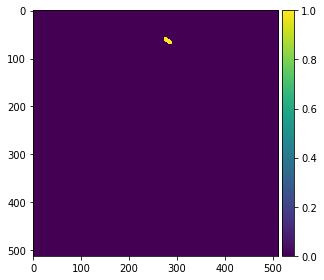

219


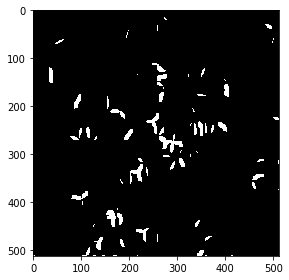

220


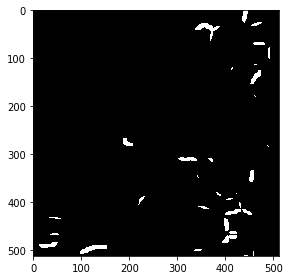

221


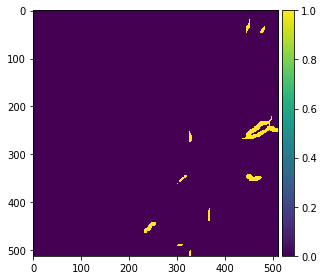

222


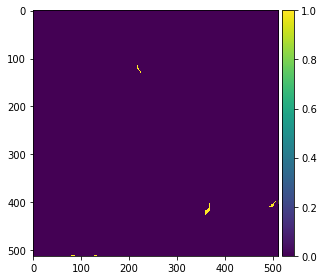

223


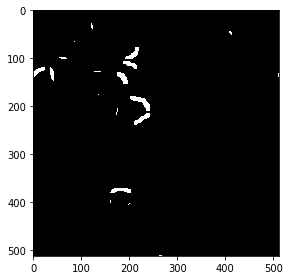

224


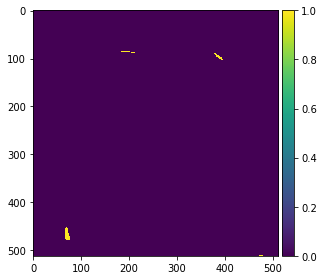

225


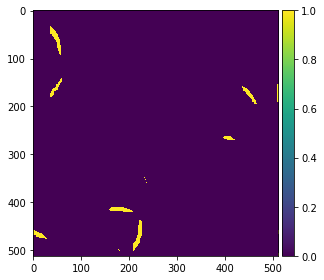

226


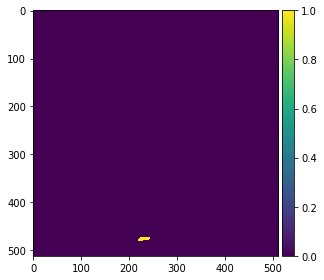

227


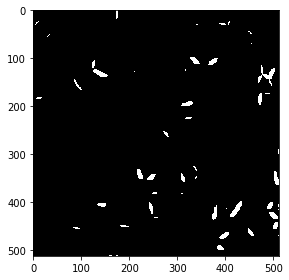

228


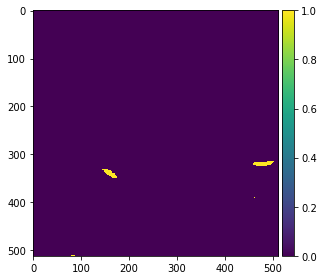

229


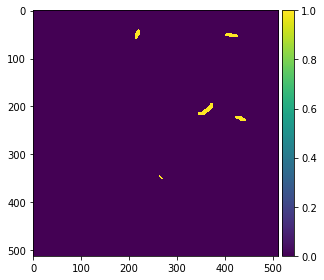

230


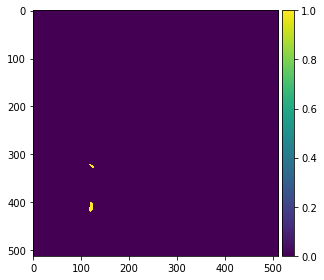

231


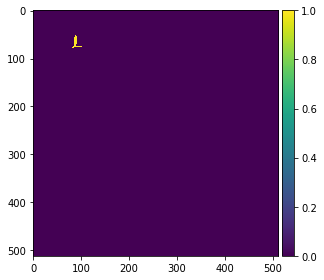

232


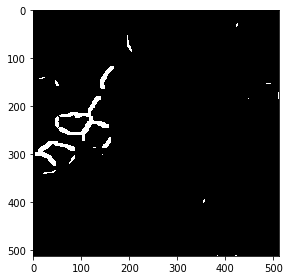

233


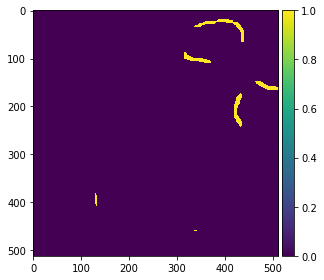

234


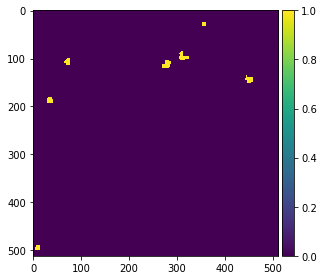

235


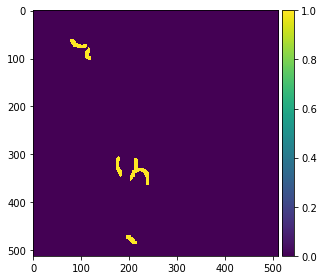

236


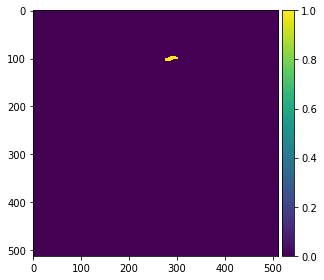

237


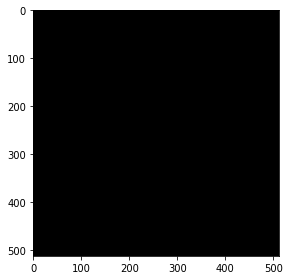

238


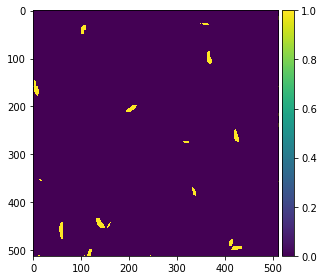

239


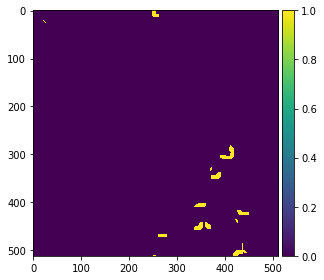

240


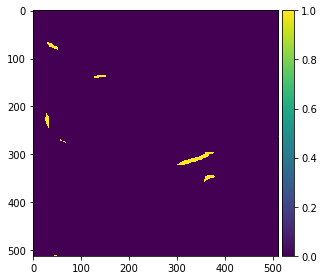

241


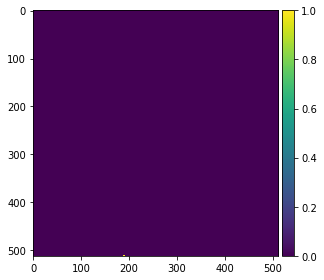

242


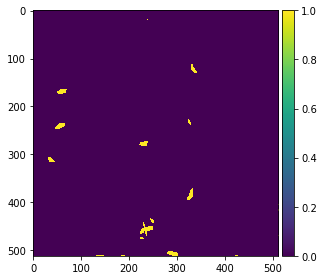

243


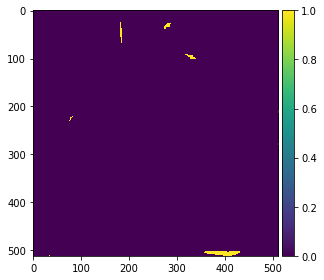

244


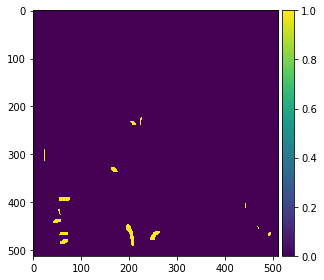

245


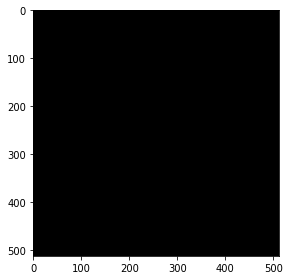

246


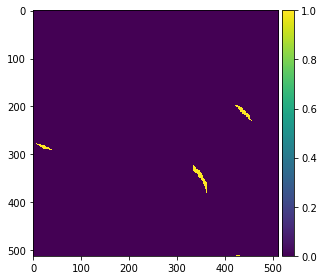

247


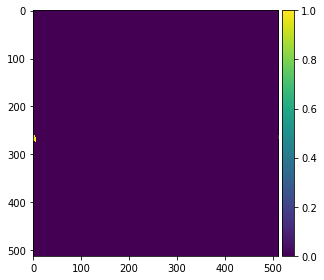

248


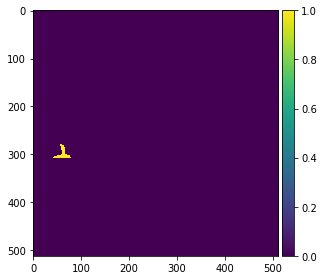

249


KeyboardInterrupt: 

In [8]:
for i in range(0,len(spaceBetweenTrain)):
    print(i)
    imshow(np.squeeze(spaceBetweenTrain[i]))
    plt.show()


Let's see if things look all right by drawing some random images and their associated masks.


(512, 512, 3)
uint8


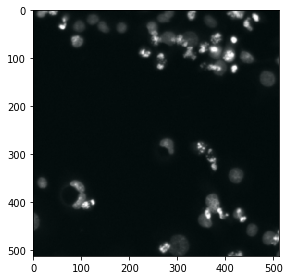

(512, 512, 1)
bool


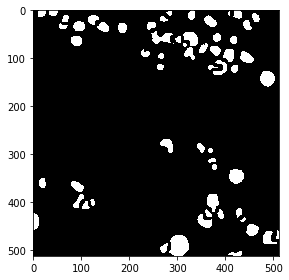

(512, 512, 1)
bool


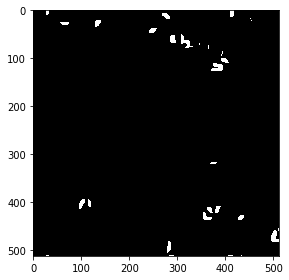

(512, 512, 2)
bool
bool


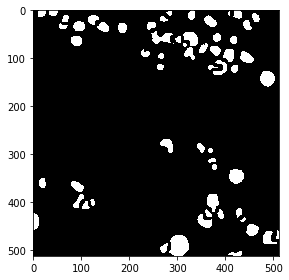

bool


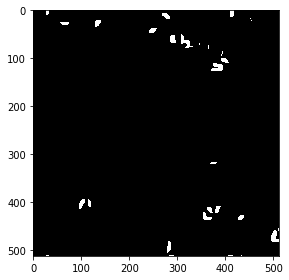

val data
(512, 512, 3)


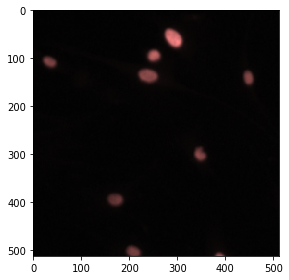

(512, 512, 1)


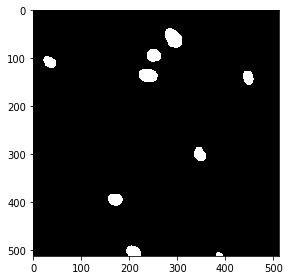

In [9]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
print(X_train[ix].shape)
print(X_train[ix].dtype)
#print(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
print(Y_train[ix].shape)
print(Y_train[ix].dtype)
plt.show()
imshow(np.squeeze(spaceBetweenTrain[ix]))
print(spaceBetweenTrain[ix].shape)
print(spaceBetweenTrain[ix].dtype)
plt.show()


print(concatenatedMasksTrain[ix].shape)
print(concatenatedMasksTrain[ix].dtype)
ma, sb = np.split(concatenatedMasksTrain, indices_or_sections = 2, axis=-1)
print(ma[ix].dtype)
imshow(np.squeeze(ma[ix]))
plt.show()
print(sb[ix].dtype)
#print(sb[ix])
imshow(np.squeeze(sb[ix]))
plt.show()


# Check if validation data looks all right
print("val data")
ix = random.randint(0, len(val_ids))
imshow(X_val[ix])
print(X_val[ix].shape)
plt.show()
imshow(np.squeeze(Y_val[ix]))
print(Y_val[ix].shape)
plt.show()

# Build and train network with augmentation

In [12]:
trainGenerator = utils.BuildGenerator(X_train_without_val, Y_train_without_val, _batchSize, DataType.trainData)
valGenerator = utils.BuildGenerator(X_val, Y_val, _batchSize, DataType.valData)

u_net = model.build_unet_inception_resnet_v2((_imgWidth, _imgHeight, _imgChannels), numberOfMaskChannels = 1)

In [ ]:
model.fit_model_generator(u_net, 
                          _modelDir, 
                          trainGenerator,
                          len(train_ids_without_val),
                          valGenerator,
                          len(val_ids),
                          _epochs, 
                          _batchSize, 
                          MaskType.nucleusMask)

Epoch 1/100
149/149 [==============================] - 95s 639ms/step - loss: 0.2196 - dice_coef: 0.8665 - dice_coef_loss: 0.1335 - binary_crossentropy: 0.0861 - binary_crossentropy_with_dice_coef_loss: 0.2196 - val_loss: 0.1718 - val_dice_coef: 0.8871 - val_dice_coef_loss: 0.1129 - val_binary_crossentropy: 0.0589 - val_binary_crossentropy_with_dice_coef_loss: 0.1718

Epoch 00001: val_loss improved from inf to 0.17182, saving model to /home/Deep_Learner/work/2018_dsb_u_net/logs/2018-07-19 20:21:01/epoch0001-val_loss0.17.h5
Epoch 2/100
149/149 [==============================] - 98s 658ms/step - loss: 0.2040 - dice_coef: 0.8763 - dice_coef_loss: 0.1237 - binary_crossentropy: 0.0804 - binary_crossentropy_with_dice_coef_loss: 0.2040 - val_loss: 0.1696 - val_dice_coef: 0.8878 - val_dice_coef_loss: 0.1122 - val_binary_crossentropy: 0.0573 - val_binary_crossentropy_with_dice_coef_loss: 0.1696

Epoch 00002: val_loss improved from 0.17182 to 0.16957, saving model to /home/Deep_Learner/work/2018

In [ ]:
trainGeneratorSpaceBetween = utils.BuildGenerator(X_train_without_val, spaceBetweenTrain_without_val, _batchSize, DataType.trainData)
valGeneratorSpaceBetween = utils.BuildGenerator(X_val, spaceBetweenVal, _batchSize, DataType.valData)
u_net_SpaceBetween = model.build_unet_inception_resnet_v2((_imgWidth, _imgHeight, _imgChannels), numberOfMaskChannels = 1)

In [ ]:
model.fit_model_generator(u_net_SpaceBetween, 
                          _modelDir, 
                          trainGeneratorSpaceBetween, 
                          len(train_ids_without_val),
                          valGeneratorSpaceBetween,
                          len(val_ids),
                          _epochs,
                          _batchSize,
                          MaskType.spaceBetweenMask)

# Start region: OBSOLETE 

# Augmentation

In [20]:
augmentedImages, augmentedMasks, augmentedSpaceBetweenMasks = utils.augment(X_train, Y_train, spaceBetweenTrain, _numberOfAugmentedImages, _imgHeight, _imgWidth, _imgChannels)
augmentedConcatenatedMasks = np.concatenate([augmentedMasks, augmentedSpaceBetweenMasks], axis=-1)

20
20
20
(20, 512, 512, 2)
(512, 512, 3)


/tmp/scikit-image/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from uint64 to float64
  .format(dtypeobj_in, dtypeobj_out))
/tmp/scikit-image/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


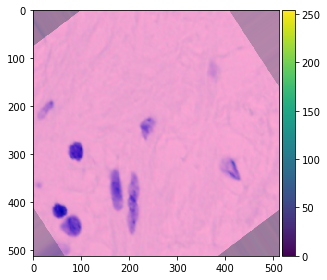

(512, 512, 1)
bool


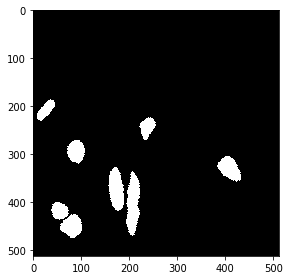

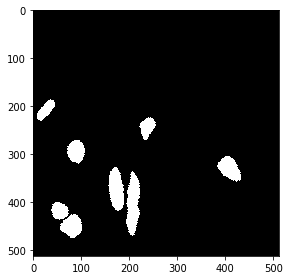

(512, 512, 1)
bool


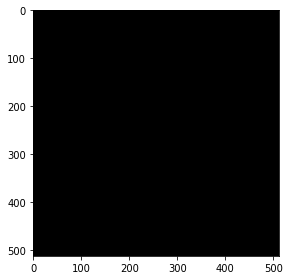

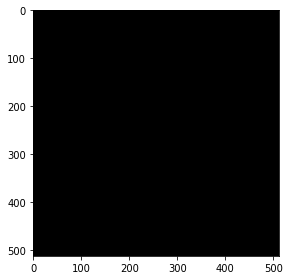

(512, 512, 3)


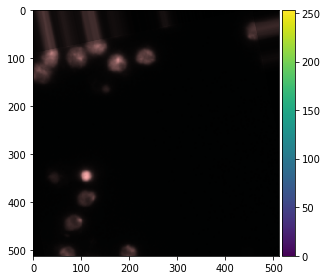

(512, 512, 1)
bool


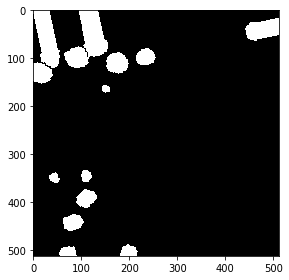

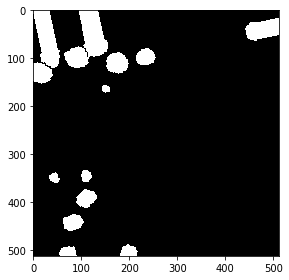

(512, 512, 1)
bool


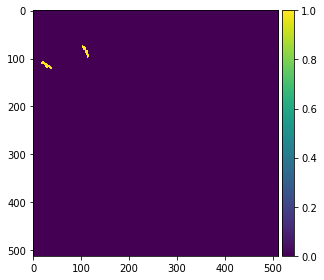

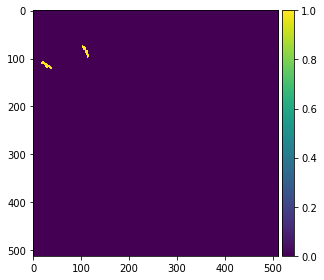

(512, 512, 3)


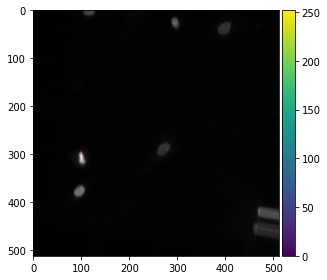

(512, 512, 1)
bool


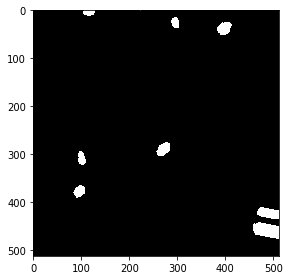

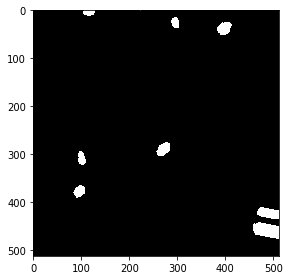

(512, 512, 1)
bool


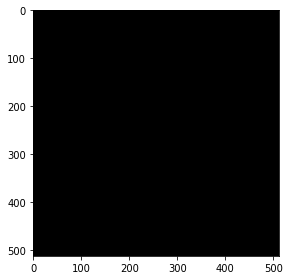

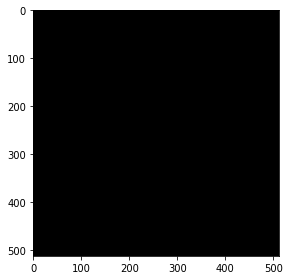

(512, 512, 3)


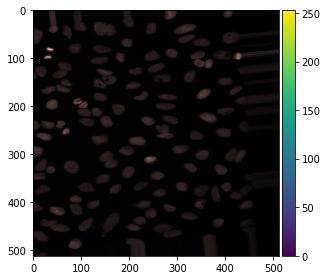

(512, 512, 1)
bool


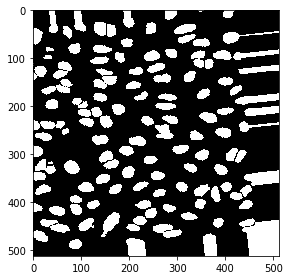

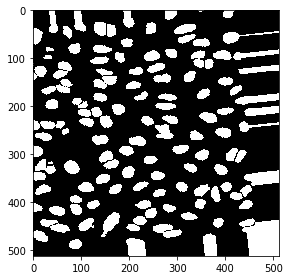

(512, 512, 1)
bool


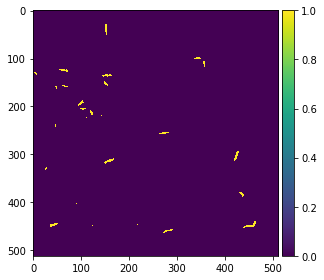

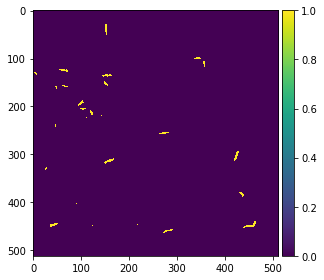

(512, 512, 3)


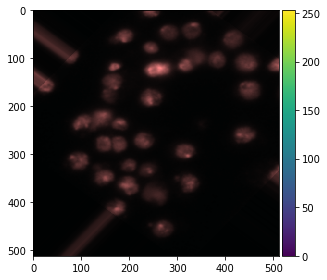

(512, 512, 1)
bool


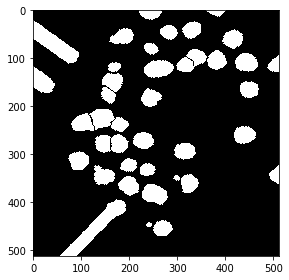

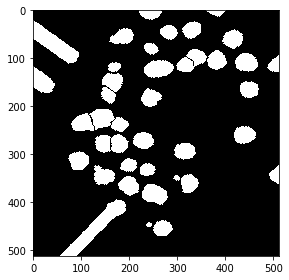

(512, 512, 1)
bool


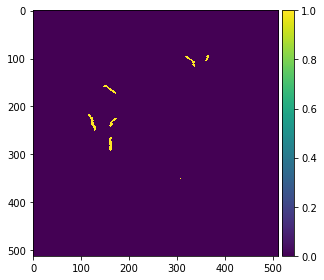

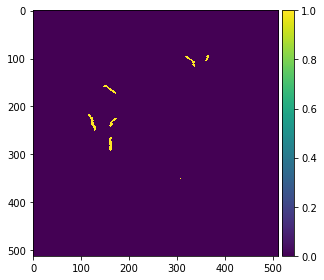

(512, 512, 3)


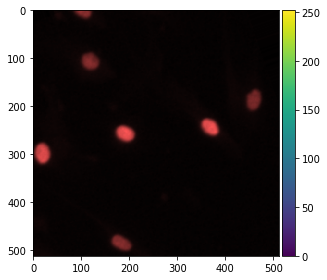

(512, 512, 1)
bool


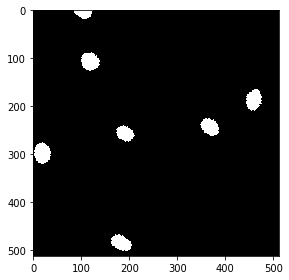

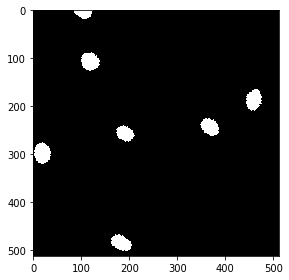

(512, 512, 1)
bool


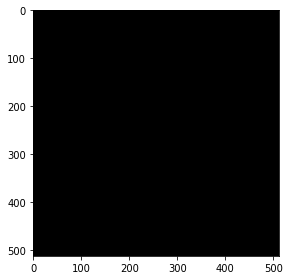

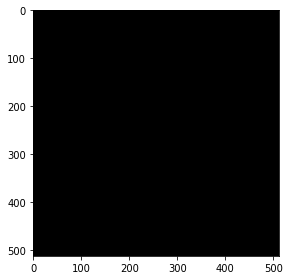

(512, 512, 3)


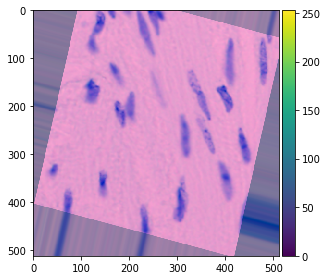

(512, 512, 1)
bool


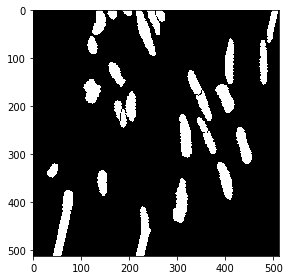

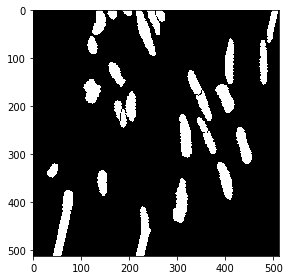

(512, 512, 1)
bool


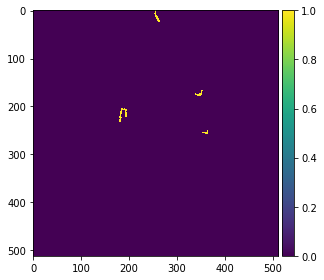

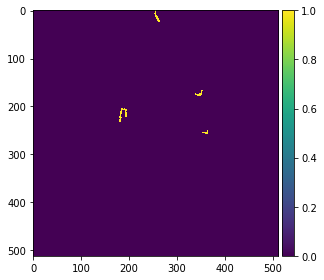

(512, 512, 3)


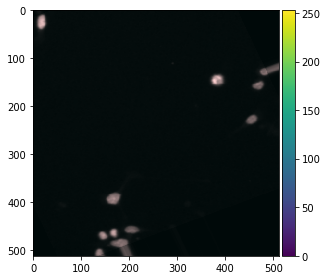

(512, 512, 1)
bool


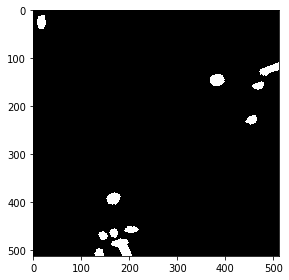

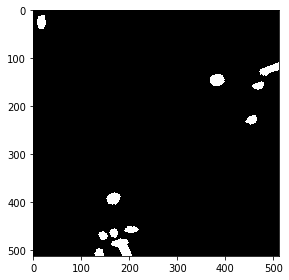

(512, 512, 1)
bool


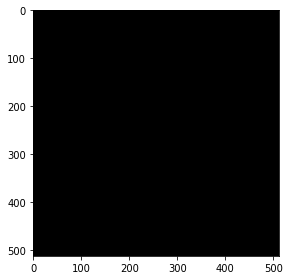

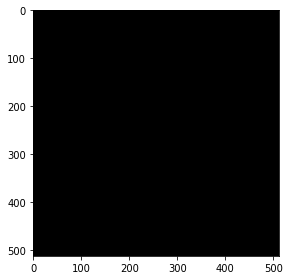

(512, 512, 3)


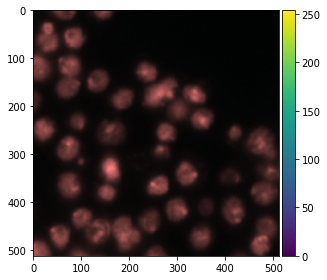

(512, 512, 1)
bool


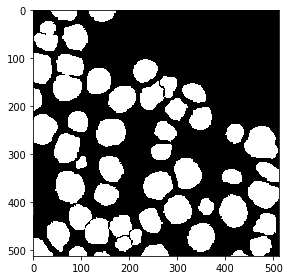

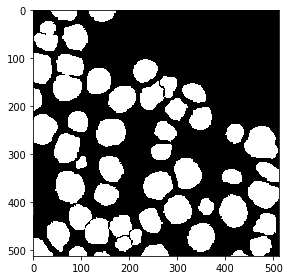

(512, 512, 1)
bool


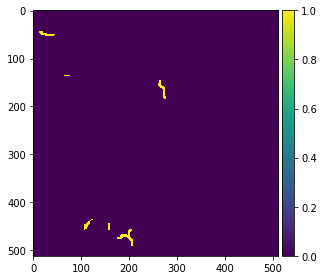

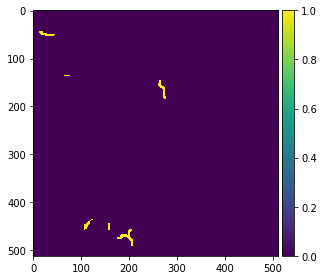

(512, 512, 3)


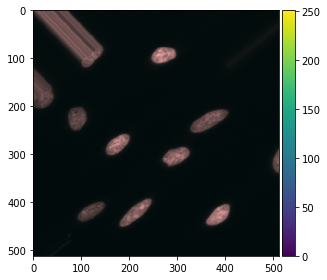

(512, 512, 1)
bool


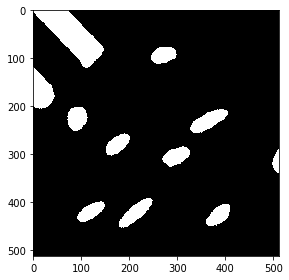

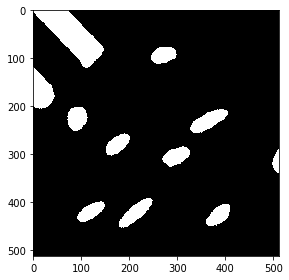

(512, 512, 1)
bool


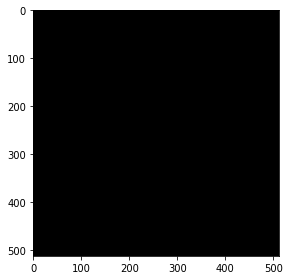

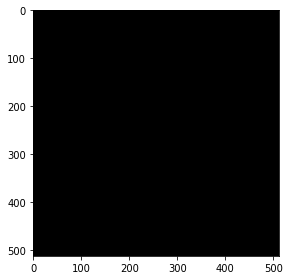

(512, 512, 3)


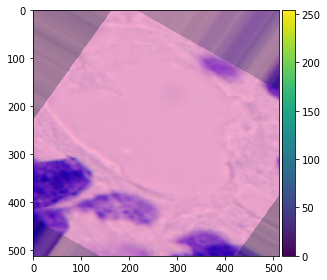

(512, 512, 1)
bool


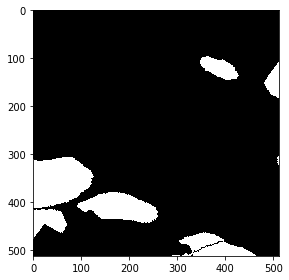

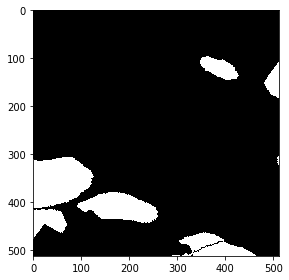

(512, 512, 1)
bool


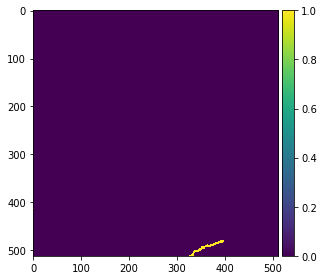

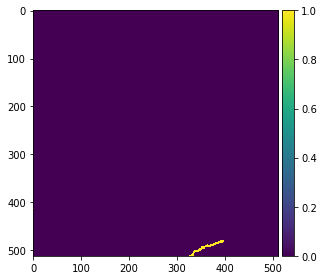

(512, 512, 3)


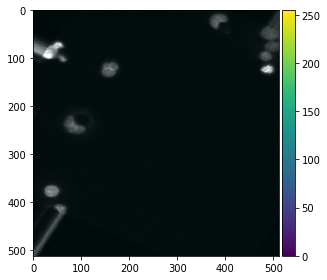

(512, 512, 1)
bool


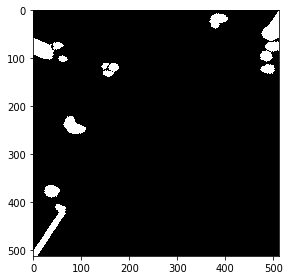

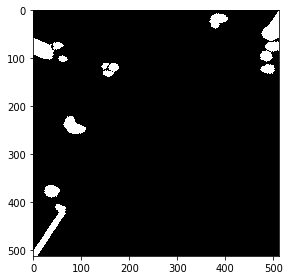

(512, 512, 1)
bool


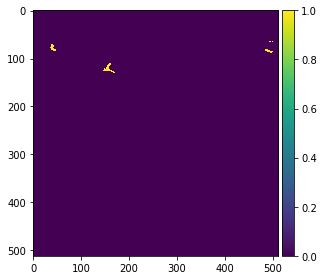

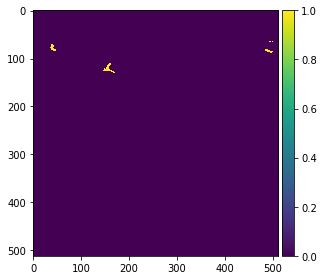

(512, 512, 3)


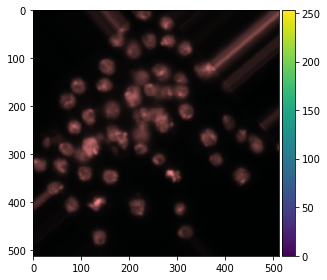

(512, 512, 1)
bool


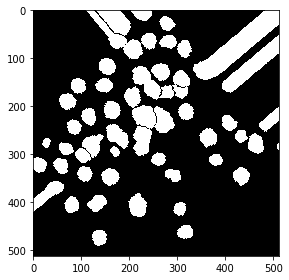

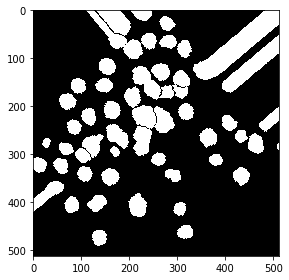

(512, 512, 1)
bool


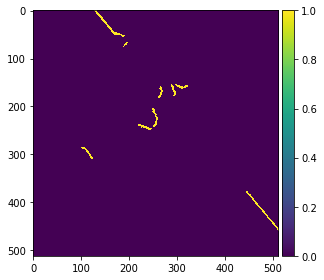

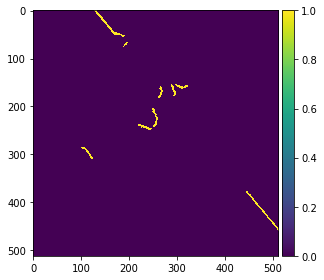

(512, 512, 3)


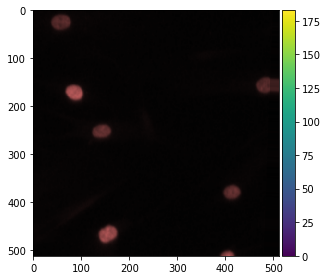

(512, 512, 1)
bool


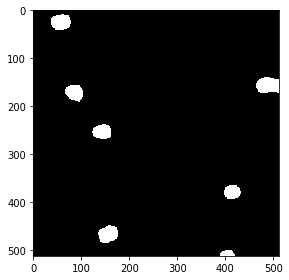

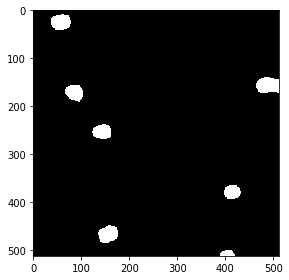

(512, 512, 1)
bool


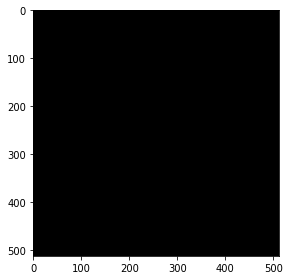

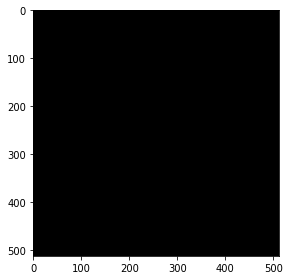

(512, 512, 3)


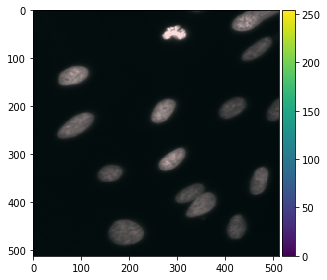

(512, 512, 1)
bool


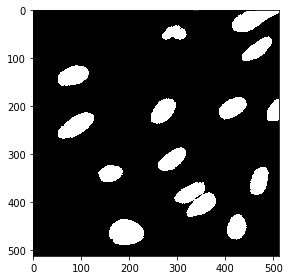

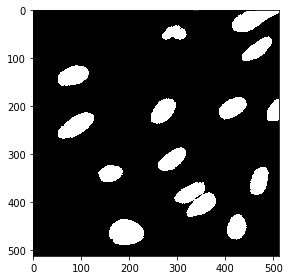

(512, 512, 1)
bool


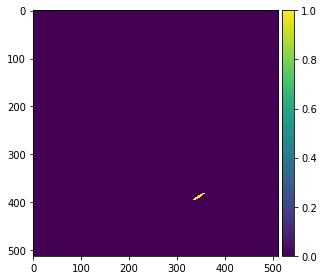

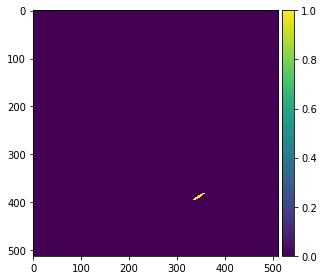

(512, 512, 3)


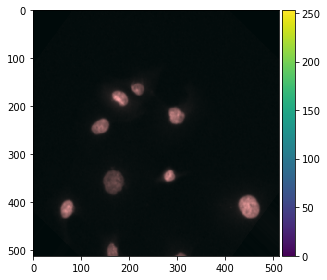

(512, 512, 1)
bool


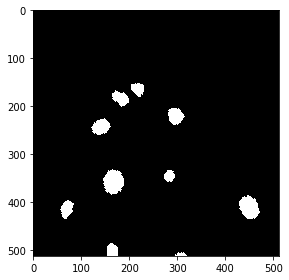

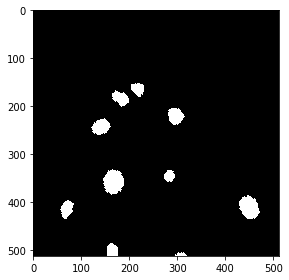

(512, 512, 1)
bool


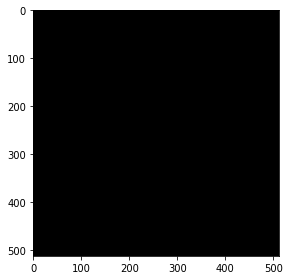

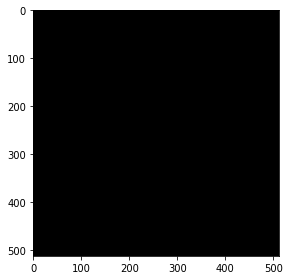

(512, 512, 3)


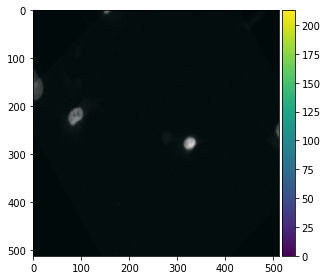

(512, 512, 1)
bool


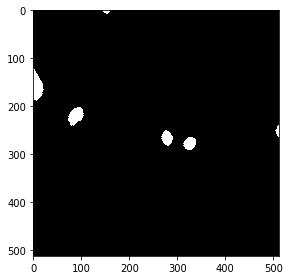

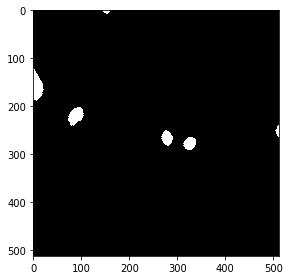

(512, 512, 1)
bool


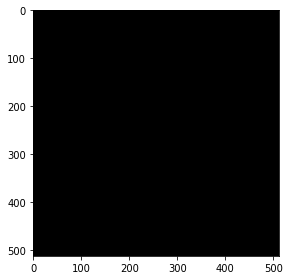

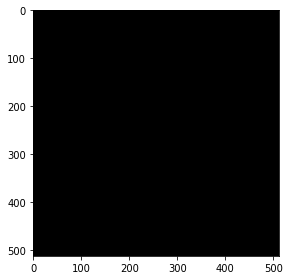

(512, 512, 3)


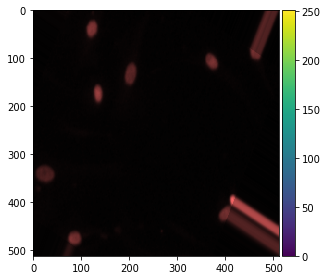

(512, 512, 1)
bool


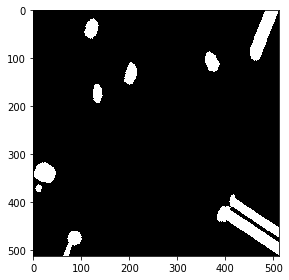

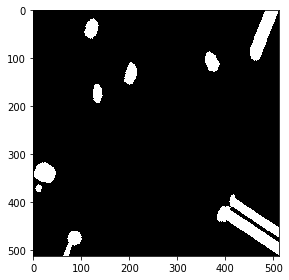

(512, 512, 1)
bool


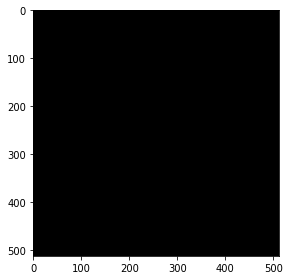

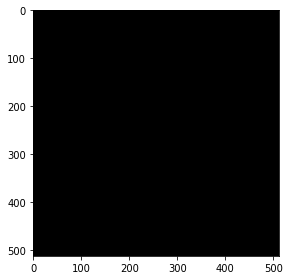

(512, 512, 3)


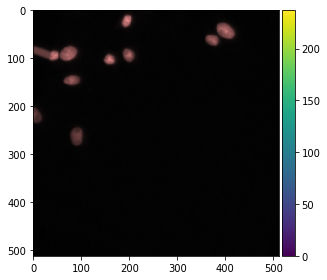

(512, 512, 1)
bool


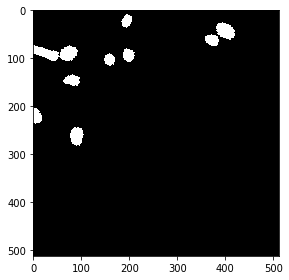

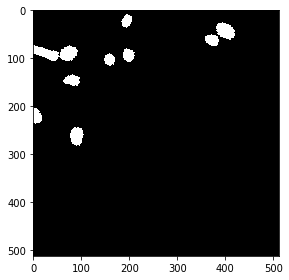

(512, 512, 1)
bool


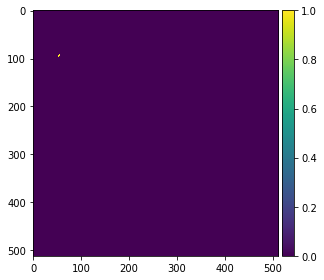

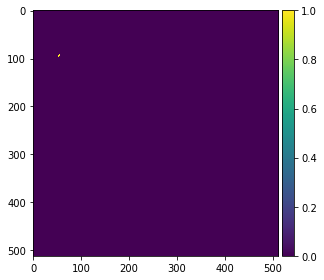

(512, 512, 3)


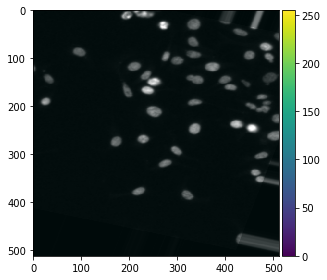

(512, 512, 1)
bool


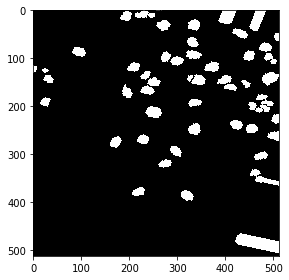

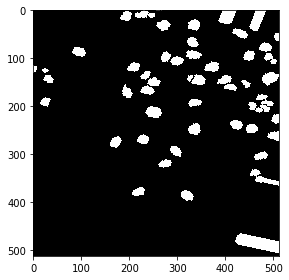

(512, 512, 1)
bool


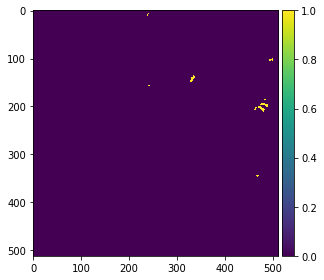

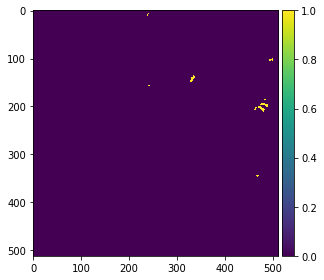

In [25]:
print(len(augmentedImages))
print(len(augmentedMasks))
print(len(augmentedSpaceBetweenMasks))
print(augmentedConcatenatedMasks.shape)
ma2, sb2 = np.split(augmentedConcatenatedMasks, 2, -1)
for i in range(0, len(augmentedImages)):
#for i in range(0, 50):
    im = augmentedImages[i]    
    print(im.shape)
    imshow(im)
    plt.show()
    
    ma = augmentedMasks[i]
    print(ma.shape)
    print(ma.dtype)
    imshow(np.squeeze(ma))
    plt.show()
    
    imshow(np.squeeze(ma2[i]))
    plt.show()
    
    sb = augmentedSpaceBetweenMasks[i]
    print(sb.shape)
    print(sb.dtype)
    imshow(np.squeeze(sb))
    plt.show()

    imshow(np.squeeze(sb2[i]))
    plt.show()

# Build and train neural network

In [4]:
u_net = model.build_unet_inception_resnet_v2((_imgWidth, _imgHeight, _imgChannels), numberOfMaskChannels = 1)

/opt/conda/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

conv2d_182 (Conv2D)             (None, 16, 16, 224)  129024      activation_181[0][0]             
__________________________________________________________________________________________________
batch_normalization_182 (BatchN (None, 16, 16, 224)  672         conv2d_182[0][0]                 
__________________________________________________________________________________________________
activation_182 (Activation)     (None, 16, 16, 224)  0           batch_normalization_182[0][0]    
__________________________________________________________________________________________________
conv2d_180 (Conv2D)             (None, 16, 16, 192)  399360      block8_4_ac[0][0]                
__________________________________________________________________________________________________
conv2d_183 (Conv2D)             (None, 16, 16, 256)  172032      activation_182[0][0]             
__________________________________________________________________________________________________
batch_norm

In [5]:
model.fit_model(u_net, _modelDir, X_train, Y_train, _validationSplit, _epochs, _batchSize)

Train on 597 samples, validate on 67 samples
Epoch 1/50
597/597 [==============================] - 153s 257ms/step - loss: 1.1424 - dice_coef: 0.2926 - dice_coef_loss: 0.7074 - binary_crossentropy: 0.4350 - binary_crossentropy_with_dice_coef_loss: 1.1424 - val_loss: 1.5837 - val_dice_coef: 0.3928 - val_dice_coef_loss: 0.6072 - val_binary_crossentropy: 0.9765 - val_binary_crossentropy_with_dice_coef_loss: 1.5837

Epoch 00001: val_loss improved from inf to 1.58375, saving model to /home/Deep_Learner/work/2018_dsb_u_net/logs/2018-06-17 11:16:22/epoch0001-val_loss1.58.h5
Epoch 2/50
597/597 [==============================] - 91s 152ms/step - loss: 0.6544 - dice_coef: 0.5067 - dice_coef_loss: 0.4933 - binary_crossentropy: 0.1611 - binary_crossentropy_with_dice_coef_loss: 0.6544 - val_loss: 0.5547 - val_dice_coef: 0.6170 - val_dice_coef_loss: 0.3830 - val_binary_crossentropy: 0.1717 - val_binary_crossentropy_with_dice_coef_loss: 0.5547

Epoch 00002: val_loss improved from 1.58375 to 0.55467, 


Epoch 00034: val_loss did not improve
Epoch 35/50
597/597 [==============================] - 93s 155ms/step - loss: 0.1331 - dice_coef: 0.9055 - dice_coef_loss: 0.0945 - binary_crossentropy: 0.0386 - binary_crossentropy_with_dice_coef_loss: 0.1331 - val_loss: 0.1491 - val_dice_coef: 0.8985 - val_dice_coef_loss: 0.1015 - val_binary_crossentropy: 0.0476 - val_binary_crossentropy_with_dice_coef_loss: 0.1491

Epoch 00035: val_loss did not improve

Epoch 00035: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Epoch 36/50
597/597 [==============================] - 93s 156ms/step - loss: 0.1358 - dice_coef: 0.9033 - dice_coef_loss: 0.0967 - binary_crossentropy: 0.0391 - binary_crossentropy_with_dice_coef_loss: 0.1358 - val_loss: 0.1487 - val_dice_coef: 0.8988 - val_dice_coef_loss: 0.1012 - val_binary_crossentropy: 0.0474 - val_binary_crossentropy_with_dice_coef_loss: 0.1487

Epoch 00036: val_loss did not improve
Epoch 37/50
597/597 [==============================] - 93s 15

In [16]:
u_net_spaceBetween = model.build_unet_inception_resnet_v2((_imgWidth, _imgHeight, _imgChannels), numberOfMaskChannels = 1)

/opt/conda/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

batch_normalization_179 (BatchN (None, 16, 16, 256)  768         conv2d_179[0][0]                 
__________________________________________________________________________________________________
activation_176 (Activation)     (None, 16, 16, 192)  0           batch_normalization_176[0][0]    
__________________________________________________________________________________________________
activation_179 (Activation)     (None, 16, 16, 256)  0           batch_normalization_179[0][0]    
__________________________________________________________________________________________________
block8_4_mixed (Concatenate)    (None, 16, 16, 448)  0           activation_176[0][0]             
                                                                 activation_179[0][0]             
__________________________________________________________________________________________________
block8_4_conv (Conv2D)          (None, 16, 16, 2080) 933920      block8_4_mixed[0][0]             
__________

In [17]:
model.fit_model(u_net_spaceBetween, _modelDir, X_train, spaceBetweenTrain, _validationSplit, _epochs, _batchSize)

Train on 597 samples, validate on 67 samples
Epoch 1/100
597/597 [==============================] - 153s 256ms/step - loss: 1.2738 - dice_coef: 0.0054 - dice_coef_loss: 0.9946 - binary_crossentropy: 0.2791 - binary_crossentropy_with_dice_coef_loss: 1.2738 - val_loss: 1.1175 - val_dice_coef: 0.0053 - val_dice_coef_loss: 0.9947 - val_binary_crossentropy: 0.1228 - val_binary_crossentropy_with_dice_coef_loss: 1.1175

Epoch 00001: val_loss improved from inf to 1.11755, saving model to /home/Deep_Learner/work/2018_dsb_u_net/logs/2018-06-19 07:51:15/epoch0001-val_loss1.12.h5
Epoch 2/100
597/597 [==============================] - 88s 147ms/step - loss: 1.0666 - dice_coef: 0.0069 - dice_coef_loss: 0.9931 - binary_crossentropy: 0.0735 - binary_crossentropy_with_dice_coef_loss: 1.0666 - val_loss: 1.0330 - val_dice_coef: 0.0071 - val_dice_coef_loss: 0.9929 - val_binary_crossentropy: 0.0401 - val_binary_crossentropy_with_dice_coef_loss: 1.0330

Epoch 00002: val_loss improved from 1.11755 to 1.03298

597/597 [==============================] - 91s 152ms/step - loss: 0.6140 - dice_coef: 0.4053 - dice_coef_loss: 0.5947 - binary_crossentropy: 0.0193 - binary_crossentropy_with_dice_coef_loss: 0.6140 - val_loss: 0.6659 - val_dice_coef: 0.3559 - val_dice_coef_loss: 0.6441 - val_binary_crossentropy: 0.0218 - val_binary_crossentropy_with_dice_coef_loss: 0.6659

Epoch 00034: val_loss improved from 0.66602 to 0.66594, saving model to /home/Deep_Learner/work/2018_dsb_u_net/logs/2018-06-19 07:51:15/epoch0034-val_loss0.67.h5
Epoch 35/100
597/597 [==============================] - 91s 152ms/step - loss: 0.6203 - dice_coef: 0.3990 - dice_coef_loss: 0.6010 - binary_crossentropy: 0.0193 - binary_crossentropy_with_dice_coef_loss: 0.6203 - val_loss: 0.6671 - val_dice_coef: 0.3542 - val_dice_coef_loss: 0.6458 - val_binary_crossentropy: 0.0213 - val_binary_crossentropy_with_dice_coef_loss: 0.6671

Epoch 00035: val_loss did not improve

Epoch 00035: ReduceLROnPlateau reducing learning rate to 3.125000148


Epoch 00051: val_loss did not improve
Epoch 52/100
597/597 [==============================] - 91s 152ms/step - loss: 0.6125 - dice_coef: 0.4065 - dice_coef_loss: 0.5935 - binary_crossentropy: 0.0191 - binary_crossentropy_with_dice_coef_loss: 0.6125 - val_loss: 0.6663 - val_dice_coef: 0.3556 - val_dice_coef_loss: 0.6444 - val_binary_crossentropy: 0.0219 - val_binary_crossentropy_with_dice_coef_loss: 0.6663

Epoch 00052: val_loss did not improve

Epoch 00052: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.
Epoch 53/100
597/597 [==============================] - 91s 152ms/step - loss: 0.6122 - dice_coef: 0.4071 - dice_coef_loss: 0.5929 - binary_crossentropy: 0.0193 - binary_crossentropy_with_dice_coef_loss: 0.6122 - val_loss: 0.6658 - val_dice_coef: 0.3561 - val_dice_coef_loss: 0.6439 - val_binary_crossentropy: 0.0218 - val_binary_crossentropy_with_dice_coef_loss: 0.6658

Epoch 00053: val_loss did not improve
Epoch 54/100
597/597 [==============================] - 91s

# End region: OBSOLETE

# Make predictions

In [7]:
preds_train, preds_val, preds_test, preds_train_t, preds_val_t, preds_test_t = model.make_predictions('./logs/2018-06-15 09:47:45/epoch0026-val_loss0.16.h5', X_train, X_val, X_test, MaskType.nucleusMask)

3018/3018 [==============================] - 120s 40ms/step


In [8]:
preds_train_spaceBetween, preds_val_spaceBetween, preds_test_spaceBetween, preds_train_t_spaceBetween, preds_val_t_spaceBetween, preds_test_t_spaceBetween = model.make_predictions('./logs/2018-06-19 07:51:15 spaceBetween/epoch0038-val_loss0.66.h5', X_train, X_val, X_test, MaskType.spaceBetweenMask)

3018/3018 [==============================] - 116s 38ms/step


In [16]:
### subtract predicted space between touching masks from the predicted test set masks
preds_test_t_subtracted = copy.deepcopy(preds_test_t)

for predictedMask, predictedSpaceBetween in tqdm(zip(preds_test_t_subtracted, preds_test_t_spaceBetween), total=len(preds_test_t_subtracted)):
    for i in range(0, predictedSpaceBetween.shape[0]):
            for j in range(0, predictedSpaceBetween.shape[1]):
                if predictedSpaceBetween[i][j] > 0:
                    predictedMask[i][j] = 0

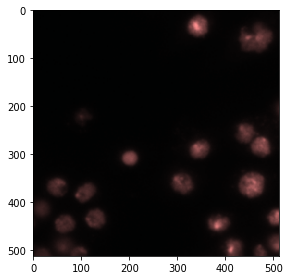

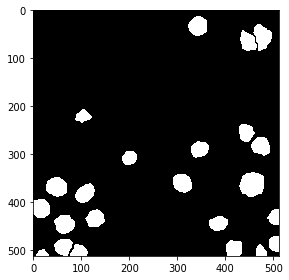

/tmp/scikit-image/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


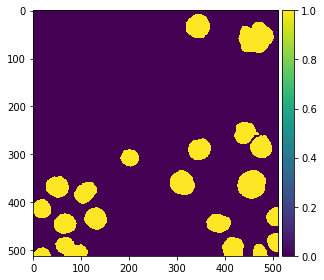

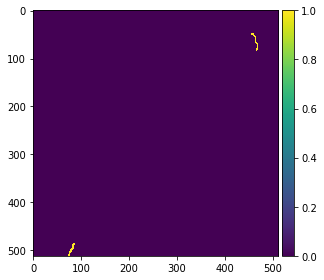

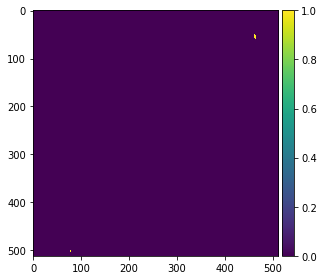

In [17]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()
imshow(np.squeeze(spaceBetweenTrain[ix]))
plt.show()
imshow(np.squeeze(preds_train_t_spaceBetween[ix]))
plt.show()

The model is at least able to fit to the training data! Certainly a lot of room for improvement even here, but a decent start. How about the validation data?

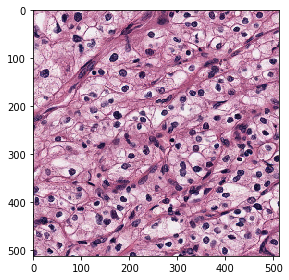

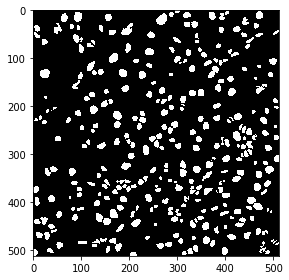

/tmp/scikit-image/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


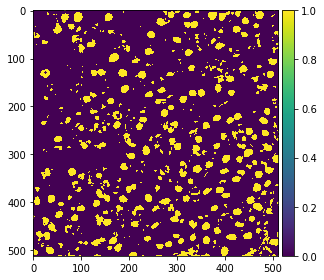

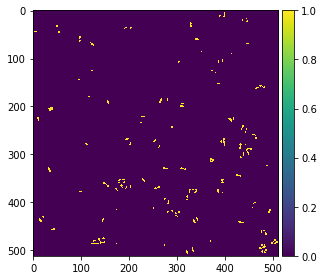

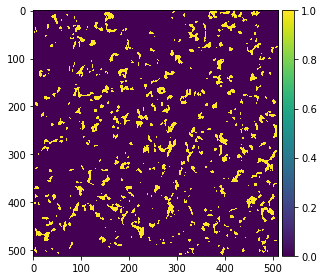

In [18]:
# Perform a sanity check on some random validation samples
"""
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
"""
ix = random.randint(0, len(preds_val_t))
imshow(X_val[ix])
plt.show()
imshow(np.squeeze(Y_val[ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
imshow(np.squeeze(spaceBetweenVal[ix]))
plt.show()
imshow(np.squeeze(preds_val_t_spaceBetween[ix]))
plt.show()

and the test data:

# Upsample test predictions to the original size

In [19]:
preds_test_t_subtracted_upsampled = model.upsamplePredictionsToOriginalSize(preds_test_t_subtracted, originalSizes = sizes_test)

/tmp/scikit-image/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


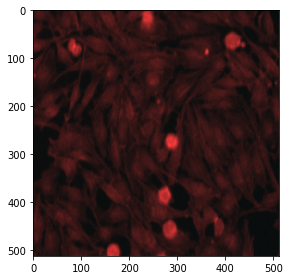

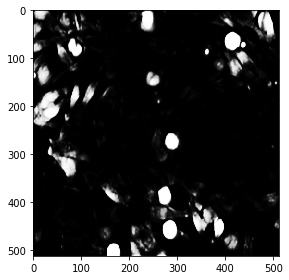

/tmp/scikit-image/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


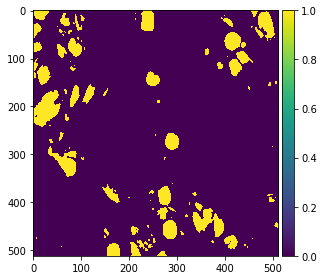

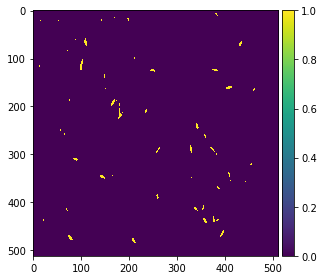

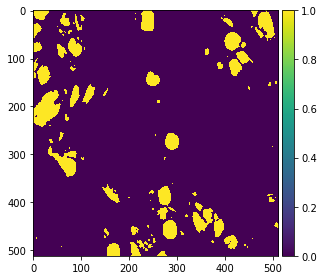

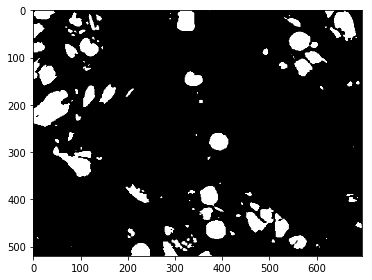

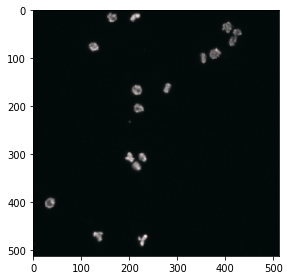

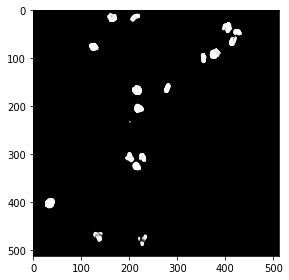

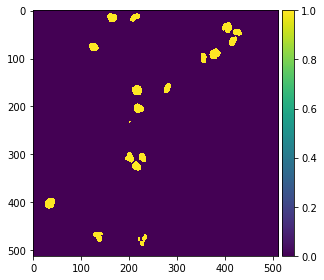

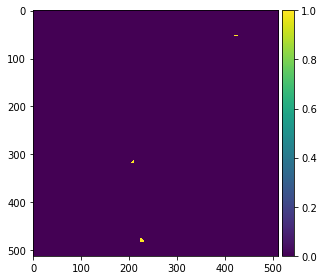

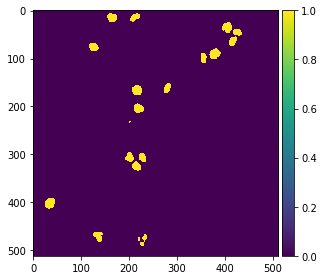

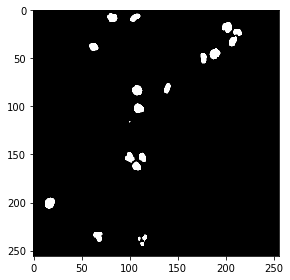

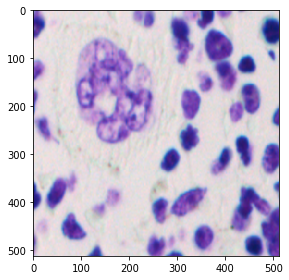

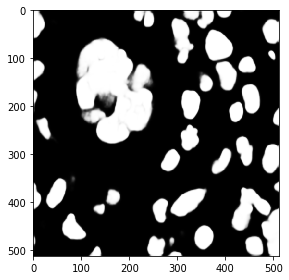

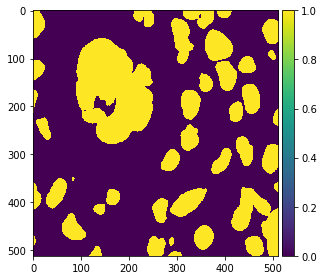

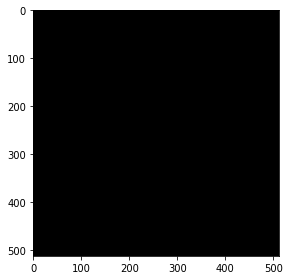

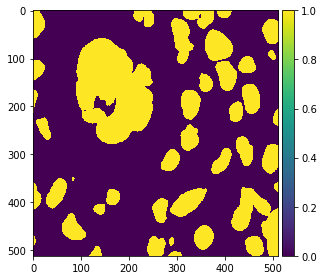

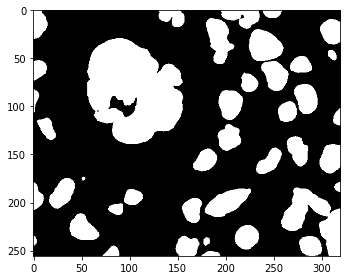

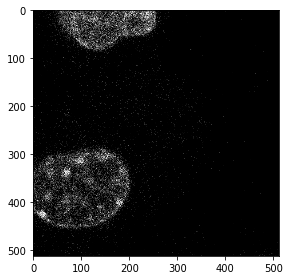

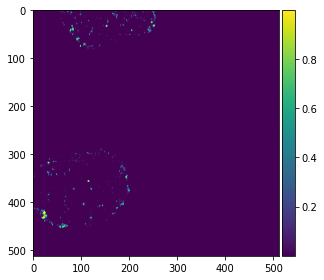

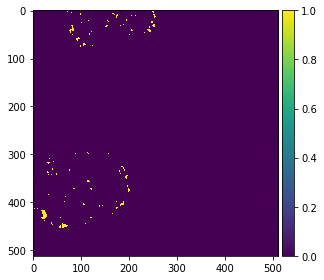

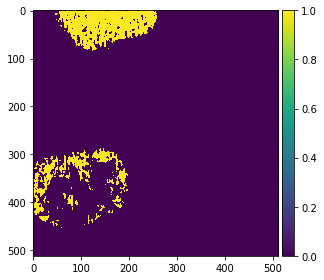

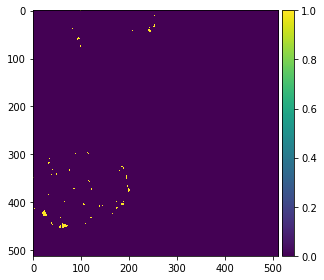

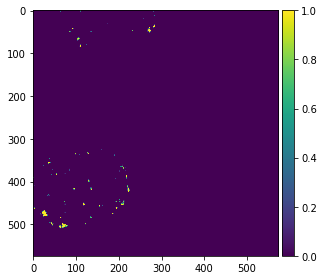

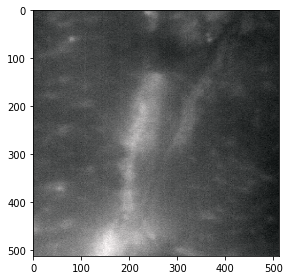

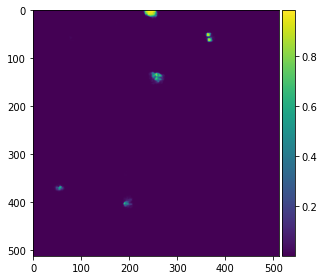

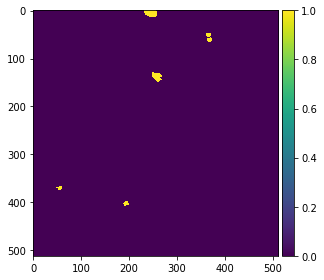

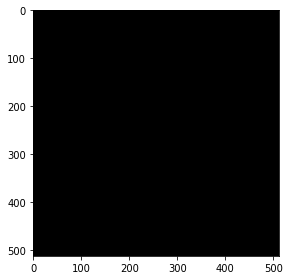

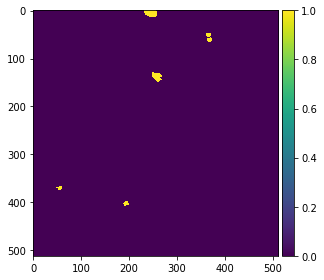

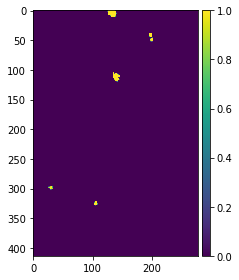

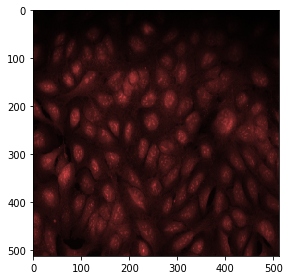

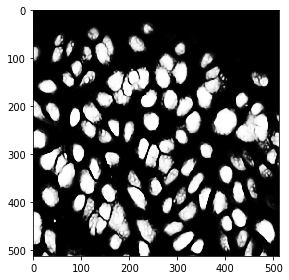

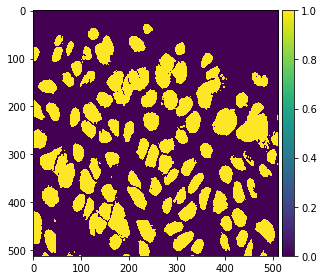

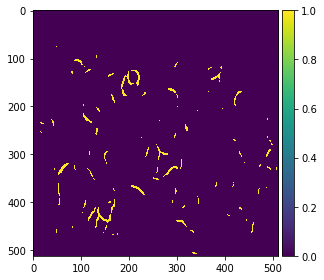

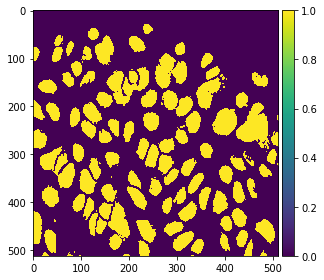

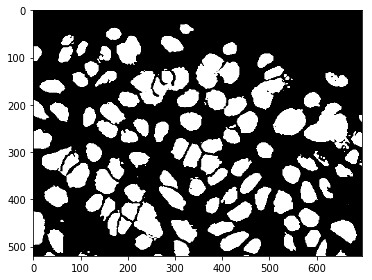

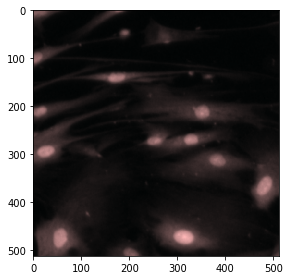

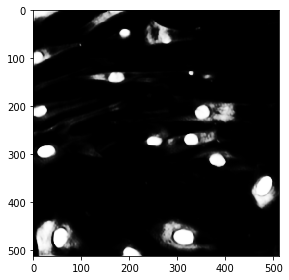

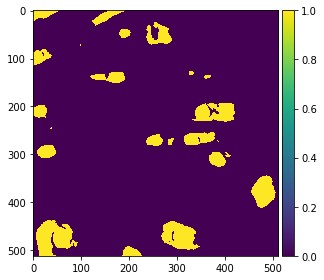

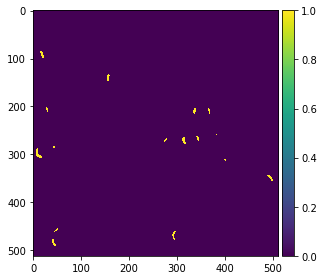

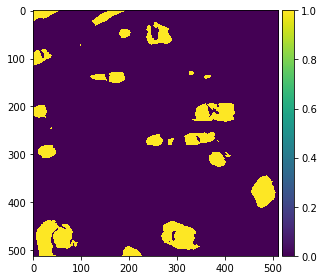

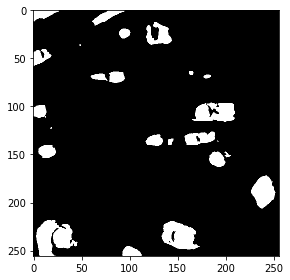

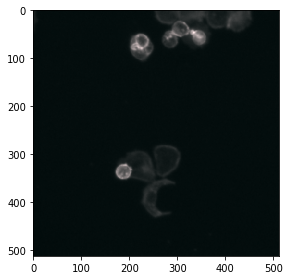

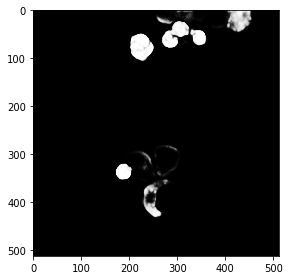

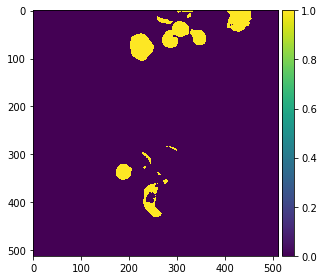

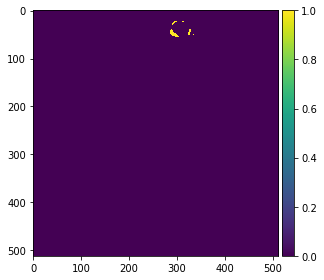

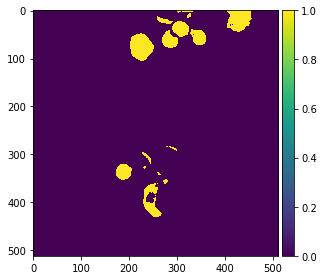

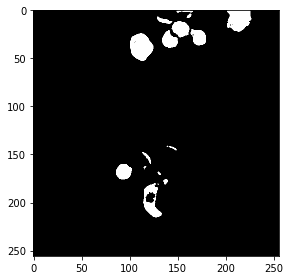

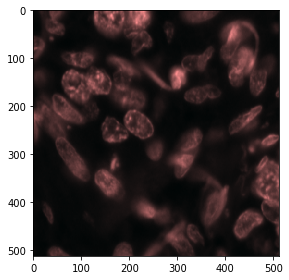

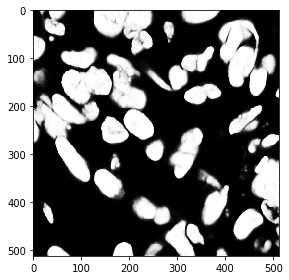

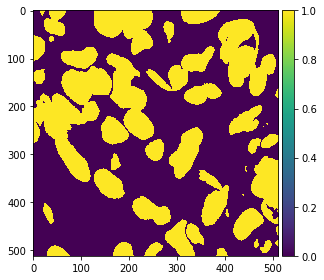

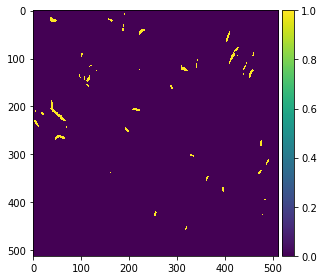

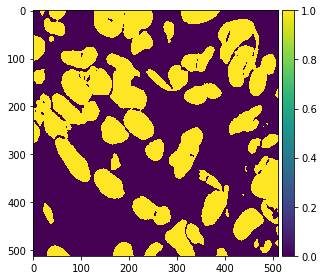

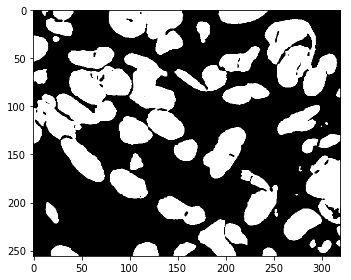

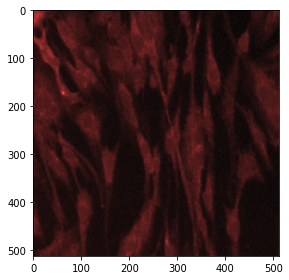

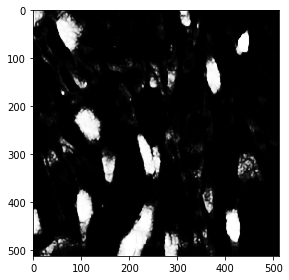

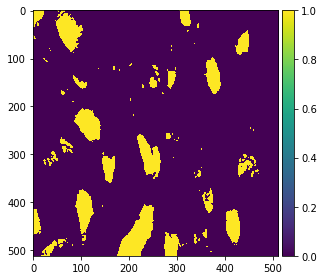

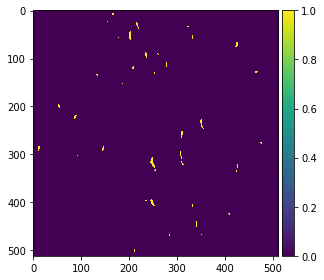

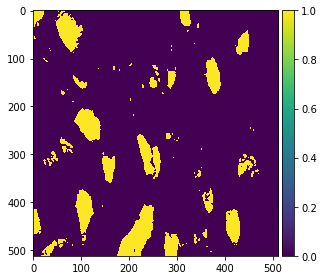

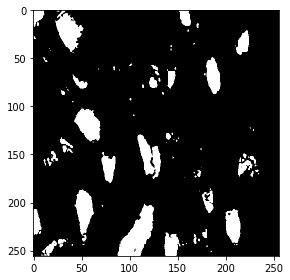

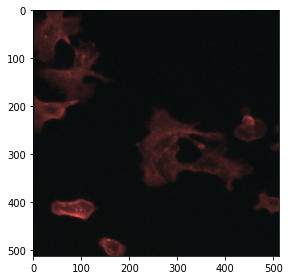

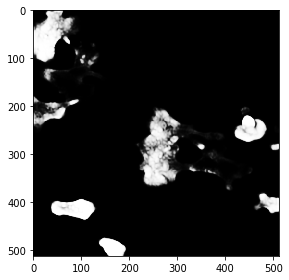

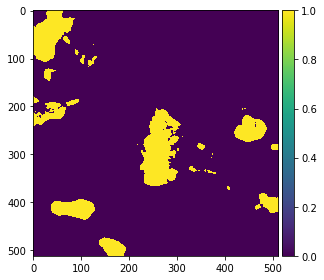

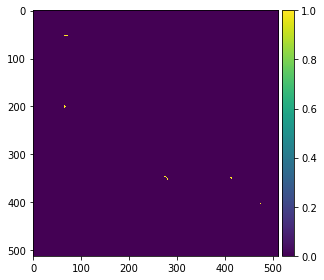

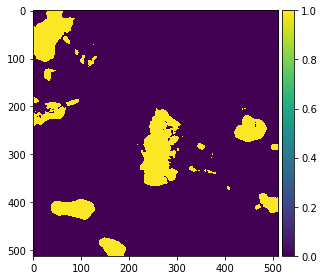

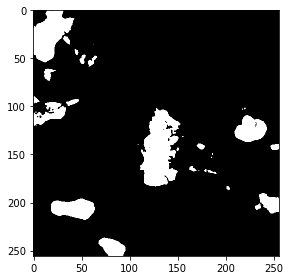

In [21]:
# Perform a sanity check on some random test sample
for i in range(0,11):
    ix = random.randint(0, len(preds_test_t_subtracted_upsampled))
    
    imshow(X_test[ix])
    plt.show()
    imshow(np.squeeze(preds_test[ix]))
    plt.show()
    imshow(np.squeeze(preds_test_t[ix]))
    plt.show()
    imshow(np.squeeze(preds_test_t_spaceBetween[ix]))
    plt.show()
    imshow(np.squeeze(preds_test_t_subtracted[ix]))
    plt.show()
    imshow(np.squeeze(preds_test_t_subtracted_upsampled[ix]))
    plt.show()

# Encode and submit our results

Now it's time to submit our results. The implementation of run-length encoding is from [here](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python)

Let's iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [54]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(utils.prob_to_rles(preds_test_t_subtracted_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

... and then finally create our submission!

In [55]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('./submissions/sub-dsbowl2018-U-Net_12.csv', index=False)